# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [14]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


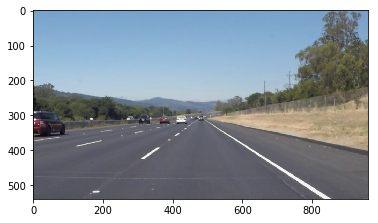

In [15]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [172]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
#     for line in lines:
#         for x1,y1,x2,y2 in line:
#             cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    right_centre = []
    right_slope = []
    left_centre = []
    left_slope = []
    x_thresh = img.shape[1]/2
    
    # Find the slope and centre of all the plausible points.
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            centre = [(x1 + x2) / 2, (y1 + y2) / 2]
            #Get rid of outliers according to the slope.
            if slope < -0.51 and centre <= x_thresh = img.shape[1]/2:
                left_centre.append(centre)
                left_slope.append(slope)
            elif slope > 0.51 and centre >= x_thresh = img.shape[1]/2:
                right_centre.append(centre)
                right_slope.append(slope) 
                    
    # Calculate the average slope and centre                
    l_slope = np.sum(left_slope) / len(left_slope)
    print ("Left: ", l_slope)
    l_centre = np.divide(np.sum(left_centre, axis=0), len(left_centre))
    r_slope = np.sum(right_slope) / len(right_slope)
    print ("Right: ", r_slope)
    r_centre = np.divide(np.sum(right_centre, axis=0), len(right_centre))
    
    # Calculate the top and bottom points to draw the line. 
    left_bottom_y = img.shape[0]
    left_bottom_x = int(l_centre[0] - (l_centre[1] - left_bottom_y) // l_slope)
    left_top_y = int(img.shape[0] * 0.58)
    left_top_x = int(l_centre[0] - (l_centre[1] - left_top_y) // l_slope)
    cv2.line(img, (left_bottom_x, left_bottom_y), (left_top_x, left_top_y), color, thickness)
    
    right_bottom_y = img.shape[0]
    right_bottom_x = int(r_centre[0] - (r_centre[1] - right_bottom_y) // r_slope)
    right_top_y = int(img.shape[0] * 0.58)
    right_top_x = int(r_centre[0] - (r_centre[1] - right_top_y) // r_slope)
    cv2.line(img, (right_bottom_x, right_bottom_y), (right_top_x, right_top_y), color, thickness)
            

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
#     plt.imshow(line_img)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

SyntaxError: invalid syntax (<ipython-input-172-de4f251daddd>, line 78)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [17]:
import os
os.listdir("test_images/")


['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [168]:
def pipeline(image):
    ysize, xsize = image.shape[0], image.shape[1]
    # Convert to gray scale.
    gray = grayscale(image)
    mpimg.imsave("test_images_output/"  + "gray" + test_image, gray, cmap="gray")

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 3
    blur_gray = gaussian_blur(gray, kernel_size)
    mpimg.imsave("test_images_output/" + "blur" + test_image, blur_gray, cmap="gray")

    # Define parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(gray, low_threshold, high_threshold)
    mpimg.imsave("test_images_output/" + "canny" + test_image, edges, cmap="gray")
#     fig, ax = plt.subplots(figsize=(20, 10))
#     ax.imshow(edges, cmap="gray")

    # Next we'll create a masked edges image using cv2.fillPoly()
    imshape = image.shape
    vertices = np.array([[(0, imshape[0]),(0.51*imshape[1], 0.58*imshape[0]), (0.49*imshape[1], 0.58*imshape[0]), 
                          (imshape[1], imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    mpimg.imsave("test_images_output/" + "masked" + test_image, masked_edges, cmap="gray")

    # Define the Hough transform parameters
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    min_line_len = xsize//16 #minimum number of pixels making up a line
    threshold = min_line_len//4 # minimum number of votes (intersections in Hough grid cell)
    max_line_gap = min_line_len//0.6 # maximum gap in pixels between connectable line segments
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    mpimg.imsave("test_images_output/" + "Hough_line" + test_image, lines, cmap="gray")

    # Combine line with original image
    lines_edges = weighted_img(lines, image, α=0.8, β=1., γ=0.)
#     ax.imshow(lines_edges)
    mpimg.imsave("test_images_output/" + test_image, lines_edges)
    return lines_edges

In [144]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
for test_image in os.listdir("test_images/"):
    image = mpimg.imread("test_images/" + test_image)
    lines_edges = pipeline(image)


487 313 877 538
Slope:  0.5769230769230769
581 364 898 539
Slope:  0.5520504731861199
594 370 899 539
Slope:  0.5540983606557377
293 462 450 331
Slope:  -0.8343949044585988
280 462 344 410
Slope:  -0.8125
290 463 458 327
Slope:  -0.8095238095238095
816 504 878 539
Slope:  0.5645161290322581
281 462 439 339
Slope:  -0.7784810126582279
405 363 484 313
Slope:  -0.6329113924050633
282 462 383 380
Slope:  -0.8118811881188119
333 420 481 313
Slope:  -0.722972972972973
555 352 854 538
Slope:  0.6220735785953178
552 351 854 539
Slope:  0.6225165562913907
487 313 835 539
Slope:  0.6494252873563219
533 342 719 463
Slope:  0.6505376344086021
187 521 439 338
Slope:  -0.7261904761904762
310 423 439 336
Slope:  -0.6744186046511628
751 486 836 539
Slope:  0.6235294117647059
189 520 475 313
Slope:  -0.7237762237762237
310 424 443 334
Slope:  -0.6766917293233082
154 538 475 313
Slope:  -0.7009345794392523
230 498 476 313
Slope:  -0.7520325203252033
154 539 477 313
Slope:  -0.6996904024767802
478 313 64

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [21]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = pipeline(image)
    plt.imshow(result)
    return result

Let's try the one with the solid white lane on the right first ...

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



 70%|██████▉   | 155/222 [03:17<01:25,  1.27s/it]


100%|█████████▉| 221/222 [04:37<00:01,  1.18s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 4min 16s, sys: 6.68 s, total: 4min 23s
Wall time: 4min 38s


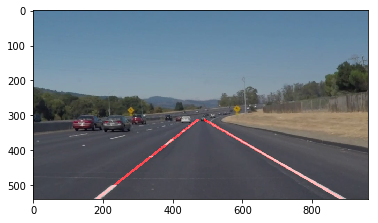

In [149]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [150]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

Left:  -0.609955024222037
Right:  0.6790853106088873
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



  0%|          | 0/682 [00:00<?, ?it/s]

Left:  -0.609955024222037
Right:  0.6790853106088873



  0%|          | 1/682 [00:01<13:47,  1.22s/it]

Left:  -0.6095299487476101
Right:  0.6814718017334533



  0%|          | 2/682 [00:03<16:01,  1.41s/it]

Left:  -0.6245338816509375
Right:  0.6757293284766132



  0%|          | 3/682 [00:04<15:30,  1.37s/it]

Left:  -0.6138916572749655
Right:  0.6527332037276481



  1%|          | 4/682 [00:05<14:31,  1.29s/it]

Left:  -0.6337180380726606
Right:  0.6659575143921858



  1%|          | 5/682 [00:06<13:43,  1.22s/it]

Left:  -0.6351816493970732
Right:  0.7001666695562748



  1%|          | 6/682 [00:07<13:06,  1.16s/it]

Left:  -0.6545919093196007
Right:  0.6421193220972471



  1%|          | 7/682 [00:08<12:41,  1.13s/it]

Left:  -0.6395073132546305
Right:  0.6688499841569031



  1%|          | 8/682 [00:09<12:21,  1.10s/it]

Left:  -0.6404666262306138
Right:  0.6502545983660115



  1%|▏         | 9/682 [00:10<12:11,  1.09s/it]

Left:  -0.6380017066744081
Right:  0.6437049647231138



  1%|▏         | 10/682 [00:11<12:02,  1.07s/it]

Left:  -0.6479103848532758
Right:  0.6517351115993851



  2%|▏         | 11/682 [00:12<12:06,  1.08s/it]

Left:  -0.6603566013146893
Right:  0.6430606445629188



  2%|▏         | 12/682 [00:13<12:05,  1.08s/it]

Left:  -0.658160480463989
Right:  0.644692263972858



  2%|▏         | 13/682 [00:15<12:09,  1.09s/it]

Left:  -0.657326681943172
Right:  0.6358163639136876



  2%|▏         | 14/682 [00:16<12:09,  1.09s/it]

Left:  -0.6645659157367805
Right:  0.6196463142454327



  2%|▏         | 15/682 [00:17<12:14,  1.10s/it]

Left:  -0.6726981395053159
Right:  0.6378673303503605



  2%|▏         | 16/682 [00:18<12:19,  1.11s/it]

Left:  -0.662304512336921
Right:  0.6678334949028719



  2%|▏         | 17/682 [00:19<12:24,  1.12s/it]

Left:  -0.6841527070737884
Right:  0.6386028270402305



  3%|▎         | 18/682 [00:20<12:26,  1.12s/it]

Left:  -0.6935676594843726
Right:  0.648447914485816



  3%|▎         | 19/682 [00:21<12:31,  1.13s/it]

Left:  -0.6871671225677485
Right:  0.6589773919100842



  3%|▎         | 20/682 [00:22<12:37,  1.14s/it]

Left:  -0.6863571813995378
Right:  0.613083213083213



  3%|▎         | 21/682 [00:24<12:32,  1.14s/it]

Left:  -0.6857704173680096
Right:  0.6347855156891302



  3%|▎         | 22/682 [00:25<12:34,  1.14s/it]

Left:  -0.6881025764761509
Right:  0.6350367123645315



  3%|▎         | 23/682 [00:26<12:40,  1.15s/it]

Left:  -0.6822082103559206
Right:  0.6524434395244887



  4%|▎         | 24/682 [00:27<12:34,  1.15s/it]

Left:  -0.6856914607621648
Right:  0.6454078537800723



  4%|▎         | 25/682 [00:28<12:31,  1.14s/it]

Left:  -0.6835030945041812
Right:  0.6215899065456588



  4%|▍         | 26/682 [00:29<12:22,  1.13s/it]

Left:  -0.6877203176387355
Right:  0.6126815147597264



  4%|▍         | 27/682 [00:30<12:18,  1.13s/it]

Left:  -0.6963638871299616
Right:  0.6176038451522528



  4%|▍         | 28/682 [00:32<12:20,  1.13s/it]

Left:  -0.701640446975408
Right:  0.5934862977116498



  4%|▍         | 29/682 [00:33<12:11,  1.12s/it]

Left:  -0.7018927067173375
Right:  0.6099490162584881



  4%|▍         | 30/682 [00:34<12:10,  1.12s/it]

Left:  -0.707942643024124
Right:  0.6043677921153271



  5%|▍         | 31/682 [00:35<12:27,  1.15s/it]

Left:  -0.7141123529410134
Right:  0.598108214222388



  5%|▍         | 32/682 [00:36<12:14,  1.13s/it]

Left:  -0.7181174831673813
Right:  0.623978288633461



  5%|▍         | 33/682 [00:37<11:59,  1.11s/it]

Left:  -0.7144602946277218
Right:  0.625



  5%|▍         | 34/682 [00:38<11:47,  1.09s/it]

Left:  -0.708579898325603
Right:  0.6151260504201681



  5%|▌         | 35/682 [00:39<11:37,  1.08s/it]

Left:  -0.7368341211498706
Right:  0.631447094967019



  5%|▌         | 36/682 [00:40<11:32,  1.07s/it]

Left:  -0.7273756708207588
Right:  0.6327511791690897



  5%|▌         | 37/682 [00:41<11:27,  1.07s/it]

Left:  -0.7533600707816852
Right:  0.6100913267305832



  6%|▌         | 38/682 [00:42<11:26,  1.07s/it]

Left:  -0.7642518982042978
Right:  0.5955876791143286



  6%|▌         | 39/682 [00:43<11:26,  1.07s/it]

Left:  -0.7333062082233233
Right:  0.5957736385538883



  6%|▌         | 40/682 [00:45<11:26,  1.07s/it]

Left:  -0.7228181548565915
Right:  0.5998567963170444



  6%|▌         | 41/682 [00:46<11:24,  1.07s/it]

Left:  -0.735233700852923
Right:  0.5885527626543575



  6%|▌         | 42/682 [00:47<11:22,  1.07s/it]

Left:  -0.7313071478311963
Right:  0.5902747189612578



  6%|▋         | 43/682 [00:48<11:22,  1.07s/it]

Left:  -0.7313698554406092
Right:  0.5882818301011111



  6%|▋         | 44/682 [00:49<11:25,  1.07s/it]

Left:  -0.7232786060762192
Right:  0.6102671345217929



  7%|▋         | 45/682 [00:50<11:27,  1.08s/it]

Left:  -0.7191475521861123
Right:  0.6560688114263439



  7%|▋         | 46/682 [00:51<11:29,  1.08s/it]

Left:  -0.7366464192867441
Right:  0.5919079933717352



  7%|▋         | 47/682 [00:52<11:33,  1.09s/it]

Left:  -0.7343324369094162
Right:  0.6125307602720362



  7%|▋         | 48/682 [00:53<11:34,  1.10s/it]

Left:  -0.7296906170560367
Right:  0.6124626970720721



  7%|▋         | 49/682 [00:54<11:39,  1.11s/it]

Left:  -0.7232344536094536
Right:  0.608171719584763



  7%|▋         | 50/682 [00:56<11:48,  1.12s/it]

Left:  -0.721138704314327
Right:  0.607450582534515



  7%|▋         | 51/682 [00:57<11:51,  1.13s/it]

Left:  -0.7234624420040641
Right:  0.6179918144529136



  8%|▊         | 52/682 [00:58<11:49,  1.13s/it]

Left:  -0.7250970501652052
Right:  0.6217191410097644



  8%|▊         | 53/682 [00:59<11:50,  1.13s/it]

Left:  -0.726802173557434
Right:  0.5858775310724824



  8%|▊         | 54/682 [01:00<11:50,  1.13s/it]

Left:  -0.7087949056320691
Right:  0.635710386435093



  8%|▊         | 55/682 [01:01<11:50,  1.13s/it]

Left:  -0.7295301108033294
Right:  0.6306872085654737



  8%|▊         | 56/682 [01:02<11:47,  1.13s/it]

Left:  -0.735140411449851
Right:  0.6642013092377744



  8%|▊         | 57/682 [01:03<11:45,  1.13s/it]

Left:  -0.7416929764483016
Right:  0.6664838177979825



  9%|▊         | 58/682 [01:05<11:50,  1.14s/it]

Left:  -0.7378499841761361
Right:  0.6896513390834883



  9%|▊         | 59/682 [01:06<11:48,  1.14s/it]

Left:  -0.7074211825742459
Right:  0.6289861539576871



  9%|▉         | 60/682 [01:07<11:45,  1.13s/it]

Left:  -0.7155029507800776
Right:  0.6354931371318616



  9%|▉         | 61/682 [01:08<11:52,  1.15s/it]

Left:  -0.708696873863525
Right:  0.5908907263410613



  9%|▉         | 62/682 [01:09<11:52,  1.15s/it]

Left:  -0.7095375531901185
Right:  0.6274963674492918



  9%|▉         | 63/682 [01:10<11:52,  1.15s/it]

Left:  -0.7088786536979413
Right:  0.6100544287637667



  9%|▉         | 64/682 [01:11<11:35,  1.12s/it]

Left:  -0.6966233479305021
Right:  0.6041777349797668



 10%|▉         | 65/682 [01:12<11:23,  1.11s/it]

Left:  -0.7075689797984347
Right:  0.6034849854953495



 10%|▉         | 66/682 [01:14<11:12,  1.09s/it]

Left:  -0.6961250479605676
Right:  0.6075243562541811



 10%|▉         | 67/682 [01:15<11:04,  1.08s/it]

Left:  -0.6934877198186165
Right:  0.6362340719832743



 10%|▉         | 68/682 [01:16<10:57,  1.07s/it]

Left:  -0.7002109434489228
Right:  0.6389636408556308



 10%|█         | 69/682 [01:17<10:53,  1.07s/it]

Left:  -0.6926007795009576
Right:  0.6623433406549382



 10%|█         | 70/682 [01:18<10:48,  1.06s/it]

Left:  -0.681358196526692
Right:  0.6613635252621489



 10%|█         | 71/682 [01:19<10:47,  1.06s/it]

Left:  -0.7044918938570688
Right:  0.5889845843055915



 11%|█         | 72/682 [01:20<10:42,  1.05s/it]

Left:  -0.6878109716547811
Right:  0.620750418651182



 11%|█         | 73/682 [01:21<10:38,  1.05s/it]

Left:  -0.6991571752853561
Right:  0.6390863481075303



 11%|█         | 74/682 [01:22<10:36,  1.05s/it]

Left:  -0.7045389217563667
Right:  0.6127315302179369



 11%|█         | 75/682 [01:23<10:36,  1.05s/it]

Left:  -0.7060741008474246
Right:  0.6217823266147976



 11%|█         | 76/682 [01:24<10:44,  1.06s/it]

Left:  -0.6906949387447893
Right:  0.613374355902242



 11%|█▏        | 77/682 [01:25<10:54,  1.08s/it]

Left:  -0.7295618925734623
Right:  0.610137484239866



 11%|█▏        | 78/682 [01:26<11:01,  1.09s/it]

Left:  -0.7219102710978567
Right:  0.6226950715628727



 12%|█▏        | 79/682 [01:27<10:58,  1.09s/it]

Left:  -0.7016637242191072
Right:  0.6146736355703173



 12%|█▏        | 80/682 [01:29<11:13,  1.12s/it]

Left:  -0.7043553381800403
Right:  0.6176780069321933



 12%|█▏        | 81/682 [01:30<11:11,  1.12s/it]

Left:  -0.7016641684930732
Right:  0.6423846584098557



 12%|█▏        | 82/682 [01:31<11:17,  1.13s/it]

Left:  -0.7047664209091973
Right:  0.6592655478516651



 12%|█▏        | 83/682 [01:32<11:15,  1.13s/it]

Left:  -0.6996642234618319
Right:  0.6491573138935507



 12%|█▏        | 84/682 [01:33<11:16,  1.13s/it]

Left:  -0.690234561706116
Right:  0.6581110901030554



 12%|█▏        | 85/682 [01:34<11:17,  1.13s/it]

Left:  -0.7083422476874243
Right:  0.626106029586904



 13%|█▎        | 86/682 [01:35<11:11,  1.13s/it]

Left:  -0.6921588703196956
Right:  0.6358526284872427



 13%|█▎        | 87/682 [01:37<11:12,  1.13s/it]

Left:  -0.6880218474364757
Right:  0.6372690846950145



 13%|█▎        | 88/682 [01:38<11:16,  1.14s/it]

Left:  -0.6858120810397538
Right:  0.6278621057242622



 13%|█▎        | 89/682 [01:39<11:20,  1.15s/it]

Left:  -0.6938911253063443
Right:  0.6388306300852957



 13%|█▎        | 90/682 [01:40<11:20,  1.15s/it]

Left:  -0.6818797046331398
Right:  0.6479753095326197



 13%|█▎        | 91/682 [01:41<11:30,  1.17s/it]

Left:  -0.6856658437949076
Right:  0.640425611149656



 13%|█▎        | 92/682 [01:42<11:23,  1.16s/it]

Left:  -0.6900507489857207
Right:  0.6511273888868934



 14%|█▎        | 93/682 [01:43<11:10,  1.14s/it]

Left:  -0.7331855857515923
Right:  0.6483340552345658



 14%|█▍        | 94/682 [01:44<10:52,  1.11s/it]

Left:  -0.7045933605755733
Right:  0.62758842319258



 14%|█▍        | 95/682 [01:46<10:40,  1.09s/it]

Left:  -0.6876745689135354
Right:  0.6532782021815648



 14%|█▍        | 96/682 [01:47<10:32,  1.08s/it]

Left:  -0.6903494275483292
Right:  0.6640025736284597



 14%|█▍        | 97/682 [01:48<10:47,  1.11s/it]

Left:  -0.7034982628991945
Right:  0.6456844027223043



 14%|█▍        | 98/682 [01:49<11:05,  1.14s/it]

Left:  -0.708256867285502
Right:  0.6495623960723251



 15%|█▍        | 99/682 [01:50<11:14,  1.16s/it]

Left:  -0.7075427542045638
Right:  0.6476260445497407



 15%|█▍        | 100/682 [01:51<11:32,  1.19s/it]

Left:  -0.689091094610526
Right:  0.6535282245473564



 15%|█▍        | 101/682 [01:53<11:26,  1.18s/it]

Left:  -0.6852468336705239
Right:  0.6370697007946936



 15%|█▍        | 102/682 [01:54<11:33,  1.20s/it]

Left:  -0.6910624498955825
Right:  0.629023252483522



 15%|█▌        | 103/682 [01:55<11:40,  1.21s/it]

Left:  -0.6814601727512161
Right:  0.6085197090132609



 15%|█▌        | 104/682 [01:56<11:42,  1.21s/it]

Left:  -0.73918513280339
Right:  0.614809695164512



 15%|█▌        | 105/682 [01:58<13:02,  1.36s/it]

Left:  -0.7055043283798461
Right:  0.6312417004771819



 16%|█▌        | 106/682 [01:59<12:38,  1.32s/it]

Left:  -0.669274715630877
Right:  0.6122071813686514



 16%|█▌        | 107/682 [02:00<12:05,  1.26s/it]

Left:  -0.6657541617043424
Right:  0.6269351519027814



 16%|█▌        | 108/682 [02:02<12:00,  1.25s/it]

Left:  -0.6717044058069127
Right:  0.6143834628555351



 16%|█▌        | 109/682 [02:03<11:37,  1.22s/it]

Left:  -0.7012061731543938
Right:  0.6539064953999736



 16%|█▌        | 110/682 [02:04<11:18,  1.19s/it]

Left:  -0.6898881798283582
Right:  0.6389482468389337



 16%|█▋        | 111/682 [02:05<11:14,  1.18s/it]

Left:  -0.6898540735890294
Right:  0.6457693405431301



 16%|█▋        | 112/682 [02:06<11:05,  1.17s/it]

Left:  -0.6691973418012522
Right:  0.636041618231954



 17%|█▋        | 113/682 [02:07<11:03,  1.17s/it]

Left:  -0.6880349371526578
Right:  0.6297939187623071



 17%|█▋        | 114/682 [02:08<11:04,  1.17s/it]

Left:  -0.7016790617163985
Right:  0.6255428268414135



 17%|█▋        | 115/682 [02:10<11:01,  1.17s/it]

Left:  -0.712254865162461
Right:  0.6351270144250037



 17%|█▋        | 116/682 [02:11<10:54,  1.16s/it]

Left:  -0.6983808874751258
Right:  0.6199944043501728



 17%|█▋        | 117/682 [02:12<10:51,  1.15s/it]

Left:  -0.687541349656818
Right:  0.6124106868956956



 17%|█▋        | 118/682 [02:13<10:51,  1.16s/it]

Left:  -0.6922853584860419
Right:  0.6450712812987699



 17%|█▋        | 119/682 [02:14<10:49,  1.15s/it]

Left:  -0.7040005888267279
Right:  0.6179760146908966



 18%|█▊        | 120/682 [02:15<10:47,  1.15s/it]

Left:  -0.6871316909548983
Right:  0.6303105596824568



 18%|█▊        | 121/682 [02:17<10:53,  1.16s/it]

Left:  -0.7032045157540429
Right:  0.627567311508771



 18%|█▊        | 122/682 [02:18<10:44,  1.15s/it]

Left:  -0.7060037162919945
Right:  0.6397948912243105



 18%|█▊        | 123/682 [02:19<10:31,  1.13s/it]

Left:  -0.7091066269375841
Right:  0.6427255943752717



 18%|█▊        | 124/682 [02:20<10:16,  1.11s/it]

Left:  -0.7144983198801482
Right:  0.6435312785174357



 18%|█▊        | 125/682 [02:21<10:06,  1.09s/it]

Left:  -0.7082733541691046
Right:  0.6126863439867737



 18%|█▊        | 126/682 [02:22<09:59,  1.08s/it]

Left:  -0.7072611513896085
Right:  0.6336644561249936



 19%|█▊        | 127/682 [02:23<09:54,  1.07s/it]

Left:  -0.7007759867240791
Right:  0.63302132928504



 19%|█▉        | 128/682 [02:24<10:01,  1.09s/it]

Left:  -0.7001024623599851
Right:  0.6072117827482706



 19%|█▉        | 129/682 [02:25<10:31,  1.14s/it]

Left:  -0.6965584293094961
Right:  0.6253596835028458



 19%|█▉        | 130/682 [02:27<11:02,  1.20s/it]

Left:  -0.6964449527026836
Right:  0.6231011042292265



 19%|█▉        | 131/682 [02:28<10:50,  1.18s/it]

Left:  -0.7000122466526278
Right:  0.6386864057955106



 19%|█▉        | 132/682 [02:29<10:35,  1.16s/it]

Left:  -0.6991380618850815
Right:  0.6267660641245547



 20%|█▉        | 133/682 [02:30<10:37,  1.16s/it]

Left:  -0.702051588682264
Right:  0.6223598678064921



 20%|█▉        | 134/682 [02:31<10:24,  1.14s/it]

Left:  -0.699778189641355
Right:  0.6248319419539397



 20%|█▉        | 135/682 [02:32<10:19,  1.13s/it]

Left:  -0.7047800868193851
Right:  0.6316094966479383



 20%|█▉        | 136/682 [02:34<10:32,  1.16s/it]

Left:  -0.6815710294767658
Right:  0.6582017831233101



 20%|██        | 137/682 [02:35<10:49,  1.19s/it]

Left:  -0.6966006074080873
Right:  0.6373065882926482



 20%|██        | 138/682 [02:36<10:41,  1.18s/it]

Left:  -0.7030112545676107
Right:  0.6255735701354271



 20%|██        | 139/682 [02:37<10:33,  1.17s/it]

Left:  -0.6604169181176024
Right:  0.6128273269504798



 21%|██        | 140/682 [02:39<11:18,  1.25s/it]

Left:  -0.6876937972868538
Right:  0.6287439524373887



 21%|██        | 141/682 [02:40<12:13,  1.36s/it]

Left:  -0.6920756858795308
Right:  0.6587194914268796



 21%|██        | 142/682 [02:42<13:28,  1.50s/it]

Left:  -0.700862720648176
Right:  0.6334141926124421



 21%|██        | 143/682 [02:43<13:04,  1.45s/it]

Left:  -0.6955004110157328
Right:  0.6003980487934498



 21%|██        | 144/682 [02:45<12:22,  1.38s/it]

Left:  -0.7077543735940803
Right:  0.6003339647136082



 21%|██▏       | 145/682 [02:46<11:49,  1.32s/it]

Left:  -0.713376349287468
Right:  0.6243928790669122



 21%|██▏       | 146/682 [02:47<11:20,  1.27s/it]

Left:  -0.7009137586291007
Right:  0.6326471726239528



 22%|██▏       | 147/682 [02:48<11:02,  1.24s/it]

Left:  -0.6992290563305054
Right:  0.641706611242215



 22%|██▏       | 148/682 [02:49<10:46,  1.21s/it]

Left:  -0.7114363725937155
Right:  0.6184974002898315



 22%|██▏       | 149/682 [02:50<10:31,  1.19s/it]

Left:  -0.7121091537688402
Right:  0.6279881397259011



 22%|██▏       | 150/682 [02:51<10:15,  1.16s/it]

Left:  -0.7153642204942984
Right:  0.6056006272790448



 22%|██▏       | 151/682 [02:53<10:14,  1.16s/it]

Left:  -0.7081746387644935
Right:  0.600530755135234



 22%|██▏       | 152/682 [02:54<10:56,  1.24s/it]

Left:  -0.7153927454105747
Right:  0.615439612895167



 22%|██▏       | 153/682 [02:55<10:40,  1.21s/it]

Left:  -0.7039859691286645
Right:  0.6069235703681809



 23%|██▎       | 154/682 [02:56<11:08,  1.27s/it]

Left:  -0.7154640552828732
Right:  0.6134196705485201



 23%|██▎       | 155/682 [02:59<13:39,  1.55s/it]

Left:  -0.7156223764491445
Right:  0.5897773882268552



 23%|██▎       | 156/682 [03:00<13:46,  1.57s/it]

Left:  -0.6948843269106981
Right:  0.5596123542221729



 23%|██▎       | 157/682 [03:02<13:09,  1.50s/it]

Left:  -0.7035739643069687
Right:  0.5905568350262409



 23%|██▎       | 158/682 [03:04<14:01,  1.61s/it]

Left:  -0.7058944210194154
Right:  0.6137002971549499



 23%|██▎       | 159/682 [03:05<13:08,  1.51s/it]

Left:  -0.7103003827122891
Right:  0.5841797093195755



 23%|██▎       | 160/682 [03:06<12:24,  1.43s/it]

Left:  -0.6966064126160144
Right:  0.6072963640030458



 24%|██▎       | 161/682 [03:08<13:00,  1.50s/it]

Left:  -0.7158618857962746
Right:  0.6142363102576983



 24%|██▍       | 162/682 [03:09<12:15,  1.41s/it]

Left:  -0.6989555894744492
Right:  0.605723950503321



 24%|██▍       | 163/682 [03:10<11:30,  1.33s/it]

Left:  -0.7117613809809864
Right:  0.5860350746239247



 24%|██▍       | 164/682 [03:11<10:57,  1.27s/it]

Left:  -0.690818383429049
Right:  0.6069609541388685



 24%|██▍       | 165/682 [03:12<10:39,  1.24s/it]

Left:  -0.6967667746289883
Right:  0.5922883230355074



 24%|██▍       | 166/682 [03:14<10:35,  1.23s/it]

Left:  -0.7083011899745868
Right:  0.5790008975301156



 24%|██▍       | 167/682 [03:15<11:00,  1.28s/it]

Left:  -0.7095281704448565
Right:  0.5734819163908009



 25%|██▍       | 168/682 [03:16<10:48,  1.26s/it]

Left:  -0.7064845634024599
Right:  0.5901188929357387



 25%|██▍       | 169/682 [03:17<10:31,  1.23s/it]

Left:  -0.7115531631958361
Right:  0.581753989793311



 25%|██▍       | 170/682 [03:19<11:05,  1.30s/it]

Left:  -0.7434159367124665
Right:  0.5708445220193341



 25%|██▌       | 171/682 [03:20<10:49,  1.27s/it]

Left:  -0.7447365600807547
Right:  0.5872086247086247



 25%|██▌       | 172/682 [03:21<10:58,  1.29s/it]

Left:  -0.7583192549892986
Right:  0.5787883891973707



 25%|██▌       | 173/682 [03:23<10:40,  1.26s/it]

Left:  -0.7180055282727528
Right:  0.5627235264416696



 26%|██▌       | 174/682 [03:24<10:25,  1.23s/it]

Left:  -0.7345400776406412
Right:  0.5888636806231742



 26%|██▌       | 175/682 [03:25<10:18,  1.22s/it]

Left:  -0.7402674533173695
Right:  0.5884003396057939



 26%|██▌       | 176/682 [03:26<10:08,  1.20s/it]

Left:  -0.7604914821558184
Right:  0.588898234035538



 26%|██▌       | 177/682 [03:27<10:10,  1.21s/it]

Left:  -0.7463818871768529
Right:  0.5852531985298143



 26%|██▌       | 178/682 [03:28<09:53,  1.18s/it]

Left:  -0.7506628558430906
Right:  0.5667875218474202



 26%|██▌       | 179/682 [03:29<09:39,  1.15s/it]

Left:  -0.7497892011087315
Right:  0.5560096454581999



 26%|██▋       | 180/682 [03:31<09:34,  1.15s/it]

Left:  -0.7355467054545957
Right:  0.5587595923958462



 27%|██▋       | 181/682 [03:32<10:02,  1.20s/it]

Left:  -0.7622363909991761
Right:  0.5294117647058824



 27%|██▋       | 182/682 [03:33<09:46,  1.17s/it]

Left:  -0.7421783816627642
Right:  0.5325168918918919



 27%|██▋       | 183/682 [03:34<09:33,  1.15s/it]

Left:  -0.7503596668868286
Right:  0.5308980643539467



 27%|██▋       | 184/682 [03:35<09:20,  1.13s/it]

Left:  -0.7638031865976236
Right:  0.5701369877685668



 27%|██▋       | 185/682 [03:36<09:13,  1.11s/it]

Left:  -0.7635967063640164
Right:  0.5643005899036756



 27%|██▋       | 186/682 [03:37<09:08,  1.11s/it]

Left:  -0.7476786095927366
Right:  0.5631474983830028



 27%|██▋       | 187/682 [03:38<09:04,  1.10s/it]

Left:  -0.7693590303554129
Right:  0.5646241886436779



 28%|██▊       | 188/682 [03:40<09:01,  1.10s/it]

Left:  -0.7690778664433601
Right:  0.5642023078769229



 28%|██▊       | 189/682 [03:41<09:04,  1.10s/it]

Left:  -0.7866279455924298
Right:  0.5518933845690384



 28%|██▊       | 190/682 [03:42<09:08,  1.11s/it]

Left:  -0.7612331897610389
Right:  0.5677815606974147



 28%|██▊       | 191/682 [03:43<09:10,  1.12s/it]

Left:  -0.7623899076025326
Right:  0.5572065991020888



 28%|██▊       | 192/682 [03:44<09:10,  1.12s/it]

Left:  -0.7892106620738177
Right:  0.5459920919213019



 28%|██▊       | 193/682 [03:45<09:13,  1.13s/it]

Left:  -0.7671814511271187
Right:  0.5634080178465991



 28%|██▊       | 194/682 [03:46<09:16,  1.14s/it]

Left:  -0.7982036103347373
Right:  0.5949013186931631



 29%|██▊       | 195/682 [03:48<09:21,  1.15s/it]

Left:  -0.7587384829945547
Right:  0.5682592715324153



 29%|██▊       | 196/682 [03:49<09:20,  1.15s/it]

Left:  -0.7603991432093686
Right:  0.57231595314253



 29%|██▉       | 197/682 [03:50<09:18,  1.15s/it]

Left:  -0.777126549031755
Right:  0.5545457283581492



 29%|██▉       | 198/682 [03:51<09:13,  1.14s/it]

Left:  -0.7728148828838451
Right:  0.5361496851297775



 29%|██▉       | 199/682 [03:52<09:13,  1.15s/it]

Left:  -0.7645411266027394
Right:  0.5731573066644907



 29%|██▉       | 200/682 [03:53<09:12,  1.15s/it]

Left:  -0.8035382527338752
Right:  0.5665492224361113



 29%|██▉       | 201/682 [03:54<09:09,  1.14s/it]

Left:  -0.7656810348070306
Right:  0.5677954351279367



 30%|██▉       | 202/682 [03:56<09:09,  1.14s/it]

Left:  -0.7685860712163132
Right:  0.5605190875904924



 30%|██▉       | 203/682 [03:57<09:15,  1.16s/it]

Left:  -0.7643108727633979
Right:  0.566762064052382



 30%|██▉       | 204/682 [03:58<09:19,  1.17s/it]

Left:  -0.7473079329751245
Right:  0.5667960725586112



 30%|███       | 205/682 [03:59<09:09,  1.15s/it]

Left:  -0.7578769001321738
Right:  0.5713238250861039



 30%|███       | 206/682 [04:00<09:03,  1.14s/it]

Left:  -0.7623696576218851
Right:  0.5627760924511295



 30%|███       | 207/682 [04:01<09:08,  1.16s/it]

Left:  -0.7410546560768237
Right:  0.5928303329023011



 30%|███       | 208/682 [04:03<09:13,  1.17s/it]

Left:  -0.7453270006155935
Right:  0.5643027018299414



 31%|███       | 209/682 [04:04<09:01,  1.14s/it]

Left:  -0.738429288413015
Right:  0.5662786512941311



 31%|███       | 210/682 [04:05<08:49,  1.12s/it]

Left:  -0.7444995363317383
Right:  0.5817745109293179



 31%|███       | 211/682 [04:06<08:54,  1.14s/it]

Left:  -0.7371578498862611
Right:  0.5994209987912674



 31%|███       | 212/682 [04:07<08:42,  1.11s/it]

Left:  -0.7394816416085577
Right:  0.5876552062036801



 31%|███       | 213/682 [04:08<08:33,  1.10s/it]

Left:  -0.7376570197132192
Right:  0.5800892779874969



 31%|███▏      | 214/682 [04:09<08:26,  1.08s/it]

Left:  -0.7202826316799184
Right:  0.5890433929897542



 32%|███▏      | 215/682 [04:10<08:22,  1.08s/it]

Left:  -0.7308259225254048
Right:  0.5870388215868605



 32%|███▏      | 216/682 [04:11<08:18,  1.07s/it]

Left:  -0.721684244421074
Right:  0.6078120050022346



 32%|███▏      | 217/682 [04:12<08:17,  1.07s/it]

Left:  -0.7274459281905311
Right:  0.6029326796702827



 32%|███▏      | 218/682 [04:13<08:17,  1.07s/it]

Left:  -0.7316026199394461
Right:  0.5858122134795563



 32%|███▏      | 219/682 [04:14<08:19,  1.08s/it]

Left:  -0.7308552146804138
Right:  0.585266606143891



 32%|███▏      | 220/682 [04:16<08:23,  1.09s/it]

Left:  -0.7321763863186295
Right:  0.5747105519713311



 32%|███▏      | 221/682 [04:17<08:27,  1.10s/it]

Left:  -0.7148387336503983
Right:  0.5941350091293416



 33%|███▎      | 222/682 [04:18<08:28,  1.11s/it]

Left:  -0.7340856238890305
Right:  0.5961706032263981



 33%|███▎      | 223/682 [04:19<08:28,  1.11s/it]

Left:  -0.7222068542103501
Right:  0.6010410141618648



 33%|███▎      | 224/682 [04:20<08:29,  1.11s/it]

Left:  -0.7268969517802116
Right:  0.6016968971724421



 33%|███▎      | 225/682 [04:21<08:37,  1.13s/it]

Left:  -0.7323137719282306
Right:  0.607147804182301



 33%|███▎      | 226/682 [04:22<08:40,  1.14s/it]

Left:  -0.7223099151238447
Right:  0.5881878836041967



 33%|███▎      | 227/682 [04:24<08:43,  1.15s/it]

Left:  -0.7375610404966746
Right:  0.5835144387824374



 33%|███▎      | 228/682 [04:25<08:55,  1.18s/it]

Left:  -0.7341393018989274
Right:  0.5932854748067077



 34%|███▎      | 229/682 [04:26<09:07,  1.21s/it]

Left:  -0.7292523831732884
Right:  0.6039766761227742



 34%|███▎      | 230/682 [04:27<08:56,  1.19s/it]

Left:  -0.7168304227645961
Right:  0.5933306061217057



 34%|███▍      | 231/682 [04:28<08:47,  1.17s/it]

Left:  -0.7105167051352492
Right:  0.6011690620129956



 34%|███▍      | 232/682 [04:30<08:47,  1.17s/it]

Left:  -0.6863964305998604
Right:  0.6297218553336958



 34%|███▍      | 233/682 [04:31<08:41,  1.16s/it]

Left:  -0.7009326124298845
Right:  0.5906668935461782



 34%|███▍      | 234/682 [04:32<08:42,  1.17s/it]

Left:  -0.7072476363454422
Right:  0.6067452602972718



 34%|███▍      | 235/682 [04:33<08:39,  1.16s/it]

Left:  -0.6875231907632804
Right:  0.6027089075321629



 35%|███▍      | 236/682 [04:34<08:37,  1.16s/it]

Left:  -0.6845106557206121
Right:  0.6086600666354295



 35%|███▍      | 237/682 [04:35<08:43,  1.18s/it]

Left:  -0.6916536535554415
Right:  0.6140307221174874



 35%|███▍      | 238/682 [04:37<08:57,  1.21s/it]

Left:  -0.680305644653053
Right:  0.6010263589510321



 35%|███▌      | 239/682 [04:38<08:53,  1.20s/it]

Left:  -0.7063738641672107
Right:  0.6059961485556553



 35%|███▌      | 240/682 [04:39<09:38,  1.31s/it]

Left:  -0.7062988353014862
Right:  0.6092993796614304



 35%|███▌      | 241/682 [04:41<09:57,  1.36s/it]

Left:  -0.6968203198922788
Right:  0.5655719017493324



 35%|███▌      | 242/682 [04:42<09:45,  1.33s/it]

Left:  -0.6927187285340349
Right:  0.5873395823342701



 36%|███▌      | 243/682 [04:43<09:30,  1.30s/it]

Left:  -0.6923042894493427
Right:  0.5919897238442942



 36%|███▌      | 244/682 [04:45<09:11,  1.26s/it]

Left:  -0.6977190573363138
Right:  0.5663332205511974



 36%|███▌      | 245/682 [04:46<08:45,  1.20s/it]

Left:  -0.6965492100390609
Right:  0.5817776022120632



 36%|███▌      | 246/682 [04:47<08:29,  1.17s/it]

Left:  -0.6827468873506517
Right:  0.5703281131354636



 36%|███▌      | 247/682 [04:48<08:17,  1.14s/it]

Left:  -0.6893784461391113
Right:  0.591440073810471



 36%|███▋      | 248/682 [04:49<08:15,  1.14s/it]

Left:  -0.6958351534192155
Right:  0.595830769564914



 37%|███▋      | 249/682 [04:50<08:21,  1.16s/it]

Left:  -0.6739945372745488
Right:  0.6049012981134166



 37%|███▋      | 250/682 [04:51<08:17,  1.15s/it]

Left:  -0.6992025010872319
Right:  0.596733059182285



 37%|███▋      | 251/682 [04:52<08:10,  1.14s/it]

Left:  -0.6936127756554746
Right:  0.6088406917492213



 37%|███▋      | 252/682 [04:53<08:10,  1.14s/it]

Left:  -0.6988509488587216
Right:  0.5832629089394914



 37%|███▋      | 253/682 [04:55<08:15,  1.15s/it]

Left:  -0.7070628613524431
Right:  0.6145903864821076



 37%|███▋      | 254/682 [04:56<08:20,  1.17s/it]

Left:  -0.7116509183611308
Right:  0.6096089887877971



 37%|███▋      | 255/682 [04:57<08:14,  1.16s/it]

Left:  -0.7097538960515224
Right:  0.5918416494166903



 38%|███▊      | 256/682 [04:58<08:39,  1.22s/it]

Left:  -0.731681573617095
Right:  0.6037146120282478



 38%|███▊      | 257/682 [05:00<08:33,  1.21s/it]

Left:  -0.7224821823362391
Right:  0.58797781995819



 38%|███▊      | 258/682 [05:01<08:33,  1.21s/it]

Left:  -0.7179641711779015
Right:  0.5965926921041101



 38%|███▊      | 259/682 [05:02<08:27,  1.20s/it]

Left:  -0.7266299377471884
Right:  0.6004307438081257



 38%|███▊      | 260/682 [05:03<08:19,  1.18s/it]

Left:  -0.7301652345905506
Right:  0.5799894545162595



 38%|███▊      | 261/682 [05:04<08:16,  1.18s/it]

Left:  -0.7407157290802151
Right:  0.6036695511630495



 38%|███▊      | 262/682 [05:06<08:40,  1.24s/it]

Left:  -0.7339500774963623
Right:  0.6131613130837786



 39%|███▊      | 263/682 [05:07<08:42,  1.25s/it]

Left:  -0.7549550641291235
Right:  0.6125300925244624



 39%|███▊      | 264/682 [05:08<08:27,  1.21s/it]

Left:  -0.7159617080161301
Right:  0.6091705991705992



 39%|███▉      | 265/682 [05:09<08:11,  1.18s/it]

Left:  -0.7122208961583402
Right:  0.5981817785294208



 39%|███▉      | 266/682 [05:10<07:57,  1.15s/it]

Left:  -0.705296641201044
Right:  0.6094170629455716



 39%|███▉      | 267/682 [05:11<07:54,  1.14s/it]

Left:  -0.7124464537329374
Right:  0.6008422149795603



 39%|███▉      | 268/682 [05:13<08:06,  1.18s/it]

Left:  -0.7111368024008143
Right:  0.6079307728608565



 39%|███▉      | 269/682 [05:14<08:01,  1.17s/it]

Left:  -0.7072735094382047
Right:  0.5845002880445749



 40%|███▉      | 270/682 [05:15<08:01,  1.17s/it]

Left:  -0.7096448209881999
Right:  0.5769636529167999



 40%|███▉      | 271/682 [05:16<08:06,  1.18s/it]

Left:  -0.680234932652649
Right:  0.5612036548804333



 40%|███▉      | 272/682 [05:17<07:53,  1.15s/it]

Left:  -0.7152424730460982
Right:  0.5864088933788746



 40%|████      | 273/682 [05:18<07:41,  1.13s/it]

Left:  -0.714730265626993
Right:  0.5859580067870723



 40%|████      | 274/682 [05:19<07:32,  1.11s/it]

Left:  -0.7196447904213276
Right:  0.5813790464737484



 40%|████      | 275/682 [05:20<07:27,  1.10s/it]

Left:  -0.7073009135161435
Right:  0.5510658562201076



 40%|████      | 276/682 [05:22<07:25,  1.10s/it]

Left:  -0.7191784834897639
Right:  0.5788397945281583



 41%|████      | 277/682 [05:23<07:27,  1.11s/it]

Left:  -0.712579317420977
Right:  0.5805969947273403



 41%|████      | 278/682 [05:24<07:59,  1.19s/it]

Left:  -0.7337871910549149
Right:  0.587285081448385



 41%|████      | 279/682 [05:26<08:48,  1.31s/it]

Left:  -0.7159679316259459
Right:  0.5744378055866698



 41%|████      | 280/682 [05:27<08:53,  1.33s/it]

Left:  -0.7164894730800844
Right:  0.5731476845322352



 41%|████      | 281/682 [05:28<08:29,  1.27s/it]

Left:  -0.7149811548971775
Right:  0.5995061944343759



 41%|████▏     | 282/682 [05:29<08:40,  1.30s/it]

Left:  -0.7178644877911323
Right:  0.5720840922631647



 41%|████▏     | 283/682 [05:31<08:35,  1.29s/it]

Left:  -0.7350470443963816
Right:  0.5616288142950756



 42%|████▏     | 284/682 [05:32<08:29,  1.28s/it]

Left:  -0.7265032056357151
Right:  0.5702334213956757



 42%|████▏     | 285/682 [05:33<08:15,  1.25s/it]

Left:  -0.7176509965809972
Right:  0.5876128685802067



 42%|████▏     | 286/682 [05:34<08:16,  1.25s/it]

Left:  -0.71764026560924
Right:  0.5800278510172829



 42%|████▏     | 287/682 [05:36<08:49,  1.34s/it]

Left:  -0.7313341120253659
Right:  0.5829567932470698



 42%|████▏     | 288/682 [05:37<08:43,  1.33s/it]

Left:  -0.7173129248548548
Right:  0.5878654663656897



 42%|████▏     | 289/682 [05:39<08:39,  1.32s/it]

Left:  -0.7353770201748626
Right:  0.5900291202188058



 43%|████▎     | 290/682 [05:40<08:20,  1.28s/it]

Left:  -0.7074514765579248
Right:  0.5896902742406324



 43%|████▎     | 291/682 [05:41<08:10,  1.25s/it]

Left:  -0.7414744237096738
Right:  0.5881316400820726



 43%|████▎     | 292/682 [05:42<08:00,  1.23s/it]

Left:  -0.7306653194705356
Right:  0.5884045106525879



 43%|████▎     | 293/682 [05:43<07:48,  1.21s/it]

Left:  -0.7293234829096553
Right:  0.6157801993836935



 43%|████▎     | 294/682 [05:44<07:41,  1.19s/it]

Left:  -0.7179747346803442
Right:  0.6084622966097506



 43%|████▎     | 295/682 [05:46<07:31,  1.17s/it]

Left:  -0.7268181271222725
Right:  0.5940022145667393



 43%|████▎     | 296/682 [05:47<07:23,  1.15s/it]

Left:  -0.7366218921163938
Right:  0.6116411219461713



 44%|████▎     | 297/682 [05:48<07:19,  1.14s/it]

Left:  -0.7143472777540146
Right:  0.6053177058013871



 44%|████▎     | 298/682 [05:49<07:18,  1.14s/it]

Left:  -0.7346847167024825
Right:  0.5776188252828981



 44%|████▍     | 299/682 [05:50<07:15,  1.14s/it]

Left:  -0.7207159235934211
Right:  0.5620949254437191



 44%|████▍     | 300/682 [05:51<07:13,  1.14s/it]

Left:  -0.7283578158575958
Right:  0.5832582618192739



 44%|████▍     | 301/682 [05:52<07:26,  1.17s/it]

Left:  -0.7181237507190508
Right:  0.6058686632027019



 44%|████▍     | 302/682 [05:54<07:19,  1.16s/it]

Left:  -0.722780596862761
Right:  0.5833873987825362



 44%|████▍     | 303/682 [05:55<07:24,  1.17s/it]

Left:  -0.7272667683615014
Right:  0.623877113254594



 45%|████▍     | 304/682 [05:56<07:26,  1.18s/it]

Left:  -0.7190675914683092
Right:  0.5933464035595598



 45%|████▍     | 305/682 [05:57<07:43,  1.23s/it]

Left:  -0.7276753061906769
Right:  0.6124800943056274



 45%|████▍     | 306/682 [05:58<07:31,  1.20s/it]

Left:  -0.717048401882925
Right:  0.6164499570024251



 45%|████▌     | 307/682 [06:00<07:27,  1.19s/it]

Left:  -0.7213903404458393
Right:  0.612206572769953



 45%|████▌     | 308/682 [06:01<07:56,  1.27s/it]

Left:  -0.7320219412975801
Right:  0.6145617262442387



 45%|████▌     | 309/682 [06:02<07:59,  1.29s/it]

Left:  -0.726901895528774
Right:  0.6307113982413106



 45%|████▌     | 310/682 [06:04<07:41,  1.24s/it]

Left:  -0.7138530543978906
Right:  0.6124900589606472



 46%|████▌     | 311/682 [06:05<07:29,  1.21s/it]

Left:  -0.7137373329989816
Right:  0.6139318059528722



 46%|████▌     | 312/682 [06:06<07:30,  1.22s/it]

Left:  -0.7088391097490828
Right:  0.612513148397762



 46%|████▌     | 313/682 [06:07<07:45,  1.26s/it]

Left:  -0.7061318215892491
Right:  0.6095516498619342



 46%|████▌     | 314/682 [06:09<07:43,  1.26s/it]

Left:  -0.7149157229294522
Right:  0.6102206580173888



 46%|████▌     | 315/682 [06:10<07:41,  1.26s/it]

Left:  -0.7102417584638563
Right:  0.5963263629719021



 46%|████▋     | 316/682 [06:11<07:24,  1.21s/it]

Left:  -0.7055959383271727
Right:  0.5994890677012431



 46%|████▋     | 317/682 [06:12<07:24,  1.22s/it]

Left:  -0.6899451916258367
Right:  0.5861003272745756



 47%|████▋     | 318/682 [06:13<07:28,  1.23s/it]

Left:  -0.713708299299619
Right:  0.5957410379698337



 47%|████▋     | 319/682 [06:15<07:29,  1.24s/it]

Left:  -0.7104713934659636
Right:  0.5920885528819254



 47%|████▋     | 320/682 [06:16<07:19,  1.21s/it]

Left:  -0.7167328345621398
Right:  0.5984035290222893



 47%|████▋     | 321/682 [06:18<08:29,  1.41s/it]

Left:  -0.742234074630191
Right:  0.5990847298513755



 47%|████▋     | 322/682 [06:19<07:53,  1.32s/it]

Left:  -0.713063706232034
Right:  0.593603218534466



 47%|████▋     | 323/682 [06:20<07:29,  1.25s/it]

Left:  -0.7154044510506096
Right:  0.594401317055572



 48%|████▊     | 324/682 [06:21<07:16,  1.22s/it]

Left:  -0.7311862369697704
Right:  0.5968878847777469



 48%|████▊     | 325/682 [06:22<07:00,  1.18s/it]

Left:  -0.7118026132566168
Right:  0.5818813480066859



 48%|████▊     | 326/682 [06:23<06:54,  1.16s/it]

Left:  -0.7049908639563253
Right:  0.5860686476702338



 48%|████▊     | 327/682 [06:24<06:57,  1.18s/it]

Left:  -0.7137069525628351
Right:  0.609274124510016



 48%|████▊     | 328/682 [06:26<07:48,  1.32s/it]

Left:  -0.7086930967954208
Right:  0.6060722893130285



 48%|████▊     | 329/682 [06:28<08:44,  1.48s/it]

Left:  -0.7121122139531897
Right:  0.6037406906512215



 48%|████▊     | 330/682 [06:29<08:12,  1.40s/it]

Left:  -0.7133408160000653
Right:  0.6050734908816724



 49%|████▊     | 331/682 [06:31<08:22,  1.43s/it]

Left:  -0.7008072121519143
Right:  0.6130887858917856



 49%|████▊     | 332/682 [06:32<07:52,  1.35s/it]

Left:  -0.7002269464146259
Right:  0.5999016805511033



 49%|████▉     | 333/682 [06:33<07:32,  1.30s/it]

Left:  -0.7126395985151287
Right:  0.6176476417369888



 49%|████▉     | 334/682 [06:34<07:25,  1.28s/it]

Left:  -0.7072339920214735
Right:  0.5770891694394115



 49%|████▉     | 335/682 [06:35<07:13,  1.25s/it]

Left:  -0.6889629048865525
Right:  0.5950017232758439



 49%|████▉     | 336/682 [06:37<07:16,  1.26s/it]

Left:  -0.6911320331331564
Right:  0.5874453958880337



 49%|████▉     | 337/682 [06:38<07:11,  1.25s/it]

Left:  -0.6900433993460404
Right:  0.6174063621791995



 50%|████▉     | 338/682 [06:39<07:05,  1.24s/it]

Left:  -0.6887361860480208
Right:  0.6095011321011945



 50%|████▉     | 339/682 [06:41<07:28,  1.31s/it]

Left:  -0.6822951996504751
Right:  0.6105957203583288



 50%|████▉     | 340/682 [06:42<07:26,  1.31s/it]

Left:  -0.6834798307065741
Right:  0.60147217363535



 50%|█████     | 341/682 [06:43<07:16,  1.28s/it]

Left:  -0.6844410743381062
Right:  0.5981104032209641



 50%|█████     | 342/682 [06:44<07:07,  1.26s/it]

Left:  -0.6869861522532572
Right:  0.6098108870021244



 50%|█████     | 343/682 [06:46<07:05,  1.25s/it]

Left:  -0.68082297100608
Right:  0.6104069308738178



 50%|█████     | 344/682 [06:47<07:11,  1.28s/it]

Left:  -0.6800640292301576
Right:  0.6096490054259601



 51%|█████     | 345/682 [06:48<07:01,  1.25s/it]

Left:  -0.6835186680537625
Right:  0.5997459843205175



 51%|█████     | 346/682 [06:49<06:46,  1.21s/it]

Left:  -0.6597756603490063
Right:  0.5950682886138046



 51%|█████     | 347/682 [06:50<06:31,  1.17s/it]

Left:  -0.6906901547437656
Right:  0.6148646803731818



 51%|█████     | 348/682 [06:51<06:21,  1.14s/it]

Left:  -0.6868583496510348
Right:  0.5969520972062439



 51%|█████     | 349/682 [06:52<06:15,  1.13s/it]

Left:  -0.696073090519676
Right:  0.6035820772069849



 51%|█████▏    | 350/682 [06:54<06:09,  1.11s/it]

Left:  -0.683922418064744
Right:  0.6005230459215686



 51%|█████▏    | 351/682 [06:55<06:05,  1.10s/it]

Left:  -0.6882552838743392
Right:  0.6067777308991233



 52%|█████▏    | 352/682 [06:56<06:00,  1.09s/it]

Left:  -0.6845995830605971
Right:  0.6126855105922866



 52%|█████▏    | 353/682 [06:57<05:57,  1.09s/it]

Left:  -0.6862284576361299
Right:  0.6032772919727355



 52%|█████▏    | 354/682 [06:58<05:54,  1.08s/it]

Left:  -0.6968200556795978
Right:  0.5959619911659798



 52%|█████▏    | 355/682 [06:59<05:52,  1.08s/it]

Left:  -0.6916259846321026
Right:  0.581090717881177



 52%|█████▏    | 356/682 [07:00<05:50,  1.07s/it]

Left:  -0.6811349672975586
Right:  0.6141635409581896



 52%|█████▏    | 357/682 [07:01<05:49,  1.08s/it]

Left:  -0.6888086633549756
Right:  0.6207767083618798



 52%|█████▏    | 358/682 [07:02<06:11,  1.15s/it]

Left:  -0.6808715305907707
Right:  0.6235623447906492



 53%|█████▎    | 359/682 [07:03<06:05,  1.13s/it]

Left:  -0.6669323132391372
Right:  0.6021468443567507



 53%|█████▎    | 360/682 [07:05<06:01,  1.12s/it]

Left:  -0.68270788874679
Right:  0.6307836060732402



 53%|█████▎    | 361/682 [07:06<06:11,  1.16s/it]

Left:  -0.6869465794710918
Right:  0.6148416139077739



 53%|█████▎    | 362/682 [07:07<06:07,  1.15s/it]

Left:  -0.7507665956838552
Right:  0.5920193170264092



 53%|█████▎    | 363/682 [07:08<06:00,  1.13s/it]

Left:  -0.6825367347443634
Right:  0.6031457710004748



 53%|█████▎    | 364/682 [07:09<05:58,  1.13s/it]

Left:  -0.6862852936646655
Right:  0.5911017549760524



 54%|█████▎    | 365/682 [07:10<05:56,  1.12s/it]

Left:  -0.6824978082449475
Right:  0.5935773877424493



 54%|█████▎    | 366/682 [07:11<05:58,  1.13s/it]

Left:  -0.7115300858255384
Right:  0.5793869525015246



 54%|█████▍    | 367/682 [07:13<06:00,  1.14s/it]

Left:  -0.6988419583048937
Right:  0.5632685776215858



 54%|█████▍    | 368/682 [07:14<06:01,  1.15s/it]

Left:  -0.6833746869620188
Right:  0.5657316896627924



 54%|█████▍    | 369/682 [07:15<06:04,  1.16s/it]

Left:  -0.6946269548436956
Right:  0.5806440053498877



 54%|█████▍    | 370/682 [07:16<06:00,  1.15s/it]

Left:  -0.6681730323209538
Right:  0.5796248818192188



 54%|█████▍    | 371/682 [07:17<05:56,  1.14s/it]

Left:  -0.7081908729339462
Right:  0.5772394577925992



 55%|█████▍    | 372/682 [07:18<05:58,  1.16s/it]

Left:  -0.7156972852643481
Right:  0.5962555888483854



 55%|█████▍    | 373/682 [07:20<05:55,  1.15s/it]

Left:  -0.7170778887008995
Right:  0.594746813435107



 55%|█████▍    | 374/682 [07:21<05:51,  1.14s/it]

Left:  -0.7185921203726564
Right:  0.604903414644201



 55%|█████▍    | 375/682 [07:22<05:51,  1.14s/it]

Left:  -0.7225875600460581
Right:  0.5966399384179089



 55%|█████▌    | 376/682 [07:23<05:49,  1.14s/it]

Left:  -0.7159303962364207
Right:  0.6044043628951279



 55%|█████▌    | 377/682 [07:24<05:59,  1.18s/it]

Left:  -0.7124788980326306
Right:  0.6008328351279972



 55%|█████▌    | 378/682 [07:25<06:00,  1.19s/it]

Left:  -0.7067979079746537
Right:  0.6068440256733822



 56%|█████▌    | 379/682 [07:27<05:54,  1.17s/it]

Left:  -0.6809683049624503
Right:  0.5960241925555212



 56%|█████▌    | 380/682 [07:28<05:47,  1.15s/it]

Left:  -0.6778996521660849
Right:  0.5903905423392829



 56%|█████▌    | 381/682 [07:29<05:43,  1.14s/it]

Left:  -0.6998012693673754
Right:  0.6071978085338285



 56%|█████▌    | 382/682 [07:30<05:38,  1.13s/it]

Left:  -0.704119731924517
Right:  0.6003840616779718



 56%|█████▌    | 383/682 [07:31<05:34,  1.12s/it]

Left:  -0.6895527234476647
Right:  0.6007270223553421



 56%|█████▋    | 384/682 [07:32<05:27,  1.10s/it]

Left:  -0.7043080448456521
Right:  0.6073422980027635



 56%|█████▋    | 385/682 [07:33<05:30,  1.11s/it]

Left:  -0.7037270521634144
Right:  0.6133740199301916



 57%|█████▋    | 386/682 [07:34<05:27,  1.11s/it]

Left:  -0.7060198350389877
Right:  0.6097481998034184



 57%|█████▋    | 387/682 [07:35<05:23,  1.10s/it]

Left:  -0.7131888957998281
Right:  0.6118258567588936



 57%|█████▋    | 388/682 [07:36<05:27,  1.11s/it]

Left:  -0.6910106039110283
Right:  0.6071125543400734



 57%|█████▋    | 389/682 [07:38<06:15,  1.28s/it]

Left:  -0.6973440295787101
Right:  0.6241472722477331



 57%|█████▋    | 390/682 [07:39<06:16,  1.29s/it]

Left:  -0.6858770220567255
Right:  0.6164615344587882



 57%|█████▋    | 391/682 [07:41<06:12,  1.28s/it]

Left:  -0.6842060094423976
Right:  0.6321641232268492



 57%|█████▋    | 392/682 [07:42<06:02,  1.25s/it]

Left:  -0.6861616500970479
Right:  0.6373713663873511



 58%|█████▊    | 393/682 [07:43<05:57,  1.24s/it]

Left:  -0.6935644674452245
Right:  0.6176641335681361



 58%|█████▊    | 394/682 [07:45<06:12,  1.29s/it]

Left:  -0.6976070172330991
Right:  0.6179669195210793



 58%|█████▊    | 395/682 [07:46<05:59,  1.25s/it]

Left:  -0.6896254170664846
Right:  0.6330795744357464



 58%|█████▊    | 396/682 [07:47<06:02,  1.27s/it]

Left:  -0.6860538845868982
Right:  0.6339817375711443



 58%|█████▊    | 397/682 [07:48<06:14,  1.31s/it]

Left:  -0.6826870023349224
Right:  0.6352464506705485



 58%|█████▊    | 398/682 [07:50<06:00,  1.27s/it]

Left:  -0.6825692153544315
Right:  0.6334765903501398



 59%|█████▊    | 399/682 [07:51<05:52,  1.24s/it]

Left:  -0.6701700482681993
Right:  0.6359218829637151



 59%|█████▊    | 400/682 [07:52<05:58,  1.27s/it]

Left:  -0.6762819752826661
Right:  0.6322894791626976



 59%|█████▉    | 401/682 [07:54<06:16,  1.34s/it]

Left:  -0.6675560405954045
Right:  0.6318530748215352



 59%|█████▉    | 402/682 [07:55<05:58,  1.28s/it]

Left:  -0.6787219387042914
Right:  0.6387371358881425



 59%|█████▉    | 403/682 [07:56<05:44,  1.23s/it]

Left:  -0.6518168749858473
Right:  0.6284861220507154



 59%|█████▉    | 404/682 [07:57<05:34,  1.20s/it]

Left:  -0.682997635236681
Right:  0.6084578438511588



 59%|█████▉    | 405/682 [07:58<05:26,  1.18s/it]

Left:  -0.6802234258810106
Right:  0.6240270441153519



 60%|█████▉    | 406/682 [07:59<05:15,  1.14s/it]

Left:  -0.6758368210358521
Right:  0.6363296141731037



 60%|█████▉    | 407/682 [08:00<05:06,  1.12s/it]

Left:  -0.6724886784729457
Right:  0.6446712891198526



 60%|█████▉    | 408/682 [08:01<05:01,  1.10s/it]

Left:  -0.678255766666776
Right:  0.6302610563066838



 60%|█████▉    | 409/682 [08:02<05:01,  1.10s/it]

Left:  -0.6488395131428437
Right:  0.6343569989667946



 60%|██████    | 410/682 [08:03<04:59,  1.10s/it]

Left:  -0.6811205820788556
Right:  0.6307766902117384



 60%|██████    | 411/682 [08:05<04:55,  1.09s/it]

Left:  -0.6849966102190019
Right:  0.6385957638521423



 60%|██████    | 412/682 [08:06<04:54,  1.09s/it]

Left:  -0.6792723729982815
Right:  0.6391768288441231



 61%|██████    | 413/682 [08:07<05:04,  1.13s/it]

Left:  -0.6836906286057941
Right:  0.6470774145751911



 61%|██████    | 414/682 [08:08<05:02,  1.13s/it]

Left:  -0.6819652698551767
Right:  0.6204460190588003



 61%|██████    | 415/682 [08:09<05:06,  1.15s/it]

Left:  -0.6825713071000009
Right:  0.6311741749571257



 61%|██████    | 416/682 [08:10<05:04,  1.14s/it]

Left:  -0.6790446788373714
Right:  0.6292388252498351



 61%|██████    | 417/682 [08:11<05:00,  1.13s/it]

Left:  -0.6762467347571514
Right:  0.6471001938713977



 61%|██████▏   | 418/682 [08:13<04:55,  1.12s/it]

Left:  -0.6675640191879527
Right:  0.6444962765837926



 61%|██████▏   | 419/682 [08:14<04:58,  1.13s/it]

Left:  -0.6834089331836838
Right:  0.6187936337333051



 62%|██████▏   | 420/682 [08:15<05:04,  1.16s/it]

Left:  -0.6773708519964791
Right:  0.6444459355947644



 62%|██████▏   | 421/682 [08:16<05:10,  1.19s/it]

Left:  -0.6790595773538027
Right:  0.6294468708573011



 62%|██████▏   | 422/682 [08:17<05:03,  1.17s/it]

Left:  -0.6700272501094415
Right:  0.6319385541155802



 62%|██████▏   | 423/682 [08:18<05:03,  1.17s/it]

Left:  -0.6806911073651286
Right:  0.633340601283436



 62%|██████▏   | 424/682 [08:20<05:02,  1.17s/it]

Left:  -0.6833964732182886
Right:  0.6158297220260146



 62%|██████▏   | 425/682 [08:21<05:04,  1.18s/it]

Left:  -0.6837619885046751
Right:  0.6083034556162904



 62%|██████▏   | 426/682 [08:22<05:07,  1.20s/it]

Left:  -0.6804184629004227
Right:  0.63764036088708



 63%|██████▎   | 427/682 [08:23<05:09,  1.21s/it]

Left:  -0.6859637515560513
Right:  0.6435102495015578



 63%|██████▎   | 428/682 [08:24<05:03,  1.20s/it]

Left:  -0.6861475178345051
Right:  0.6340492695994894



 63%|██████▎   | 429/682 [08:26<04:57,  1.17s/it]

Left:  -0.6920560255488772
Right:  0.6173077304192577



 63%|██████▎   | 430/682 [08:27<04:54,  1.17s/it]

Left:  -0.6897543331005853
Right:  0.6302503214332533



 63%|██████▎   | 431/682 [08:28<04:55,  1.18s/it]

Left:  -0.6851844577505329
Right:  0.6602992586287987



 63%|██████▎   | 432/682 [08:29<04:50,  1.16s/it]

Left:  -0.6864724374721433
Right:  0.6352174759335537



 63%|██████▎   | 433/682 [08:30<04:48,  1.16s/it]

Left:  -0.6829476372920501
Right:  0.6277166441014951



 64%|██████▎   | 434/682 [08:31<04:45,  1.15s/it]

Left:  -0.6839631615869247
Right:  0.6591248334764132



 64%|██████▍   | 435/682 [08:32<04:41,  1.14s/it]

Left:  -0.6851636964847438
Right:  0.6535441897010479



 64%|██████▍   | 436/682 [08:34<04:36,  1.12s/it]

Left:  -0.6816321423217871
Right:  0.6359951985681094



 64%|██████▍   | 437/682 [08:35<04:38,  1.14s/it]

Left:  -0.6868558503320349
Right:  0.6306039645009112



 64%|██████▍   | 438/682 [08:36<04:40,  1.15s/it]

Left:  -0.6840904878249381
Right:  0.6456338745811252



 64%|██████▍   | 439/682 [08:37<04:45,  1.17s/it]

Left:  -0.6787445101643682
Right:  0.6257921149114282



 65%|██████▍   | 440/682 [08:38<04:39,  1.15s/it]

Left:  -0.6830149121929854
Right:  0.6098250671597202



 65%|██████▍   | 441/682 [08:39<04:31,  1.13s/it]

Left:  -0.6797101995765479
Right:  0.6273473120648293



 65%|██████▍   | 442/682 [08:40<04:26,  1.11s/it]

Left:  -0.6707272355500377
Right:  0.6241861122803325



 65%|██████▍   | 443/682 [08:41<04:23,  1.10s/it]

Left:  -0.6818445640074782
Right:  0.6399700133560666



 65%|██████▌   | 444/682 [08:43<04:23,  1.11s/it]

Left:  -0.6736418874582093
Right:  0.6269484548228564



 65%|██████▌   | 445/682 [08:44<04:22,  1.11s/it]

Left:  -0.6783835629115452
Right:  0.6359926722840393



 65%|██████▌   | 446/682 [08:45<04:20,  1.10s/it]

Left:  -0.6820383503261073
Right:  0.628476093385076



 66%|██████▌   | 447/682 [08:46<04:17,  1.09s/it]

Left:  -0.6844091344550514
Right:  0.6125423607892843



 66%|██████▌   | 448/682 [08:47<04:17,  1.10s/it]

Left:  -0.6844946702230885
Right:  0.641727870336395



 66%|██████▌   | 449/682 [08:48<04:18,  1.11s/it]

Left:  -0.6810089317497041
Right:  0.6276909812420877



 66%|██████▌   | 450/682 [08:49<04:19,  1.12s/it]

Left:  -0.6826085283466656
Right:  0.6363764059007284



 66%|██████▌   | 451/682 [08:51<04:29,  1.17s/it]

Left:  -0.6829295217991713
Right:  0.6381283195013715



 66%|██████▋   | 452/682 [08:52<04:26,  1.16s/it]

Left:  -0.6842377753109863
Right:  0.6332669647676163



 66%|██████▋   | 453/682 [08:53<04:25,  1.16s/it]

Left:  -0.6835141195991615
Right:  0.6339762734722397



 67%|██████▋   | 454/682 [08:54<04:24,  1.16s/it]

Left:  -0.6814574530135759
Right:  0.6172413714540766



 67%|██████▋   | 455/682 [08:55<04:22,  1.16s/it]

Left:  -0.6824093217250303
Right:  0.6488058985417439



 67%|██████▋   | 456/682 [08:56<04:24,  1.17s/it]

Left:  -0.6632690875643247
Right:  0.6449134915219794



 67%|██████▋   | 457/682 [08:58<04:29,  1.20s/it]

Left:  -0.6662611430269191
Right:  0.6510447329200103



 67%|██████▋   | 458/682 [08:59<04:25,  1.18s/it]

Left:  -0.6622688013277411
Right:  0.6350519443459198



 67%|██████▋   | 459/682 [09:00<04:24,  1.18s/it]

Left:  -0.6632003083626817
Right:  0.637648484738182



 67%|██████▋   | 460/682 [09:01<04:24,  1.19s/it]

Left:  -0.6630415464362196
Right:  0.6244932820490801



 68%|██████▊   | 461/682 [09:02<04:21,  1.18s/it]

Left:  -0.6741424226925904
Right:  0.6397174176645973



 68%|██████▊   | 462/682 [09:03<04:19,  1.18s/it]

Left:  -0.6728555774396402
Right:  0.6172090961307877



 68%|██████▊   | 463/682 [09:05<04:17,  1.18s/it]

Left:  -0.6684288150078951
Right:  0.6382327563645726



 68%|██████▊   | 464/682 [09:06<04:15,  1.17s/it]

Left:  -0.6751819580684634
Right:  0.6055063149923017



 68%|██████▊   | 465/682 [09:07<04:15,  1.18s/it]

Left:  -0.6759730268058185
Right:  0.6485383851060321



 68%|██████▊   | 466/682 [09:08<04:12,  1.17s/it]

Left:  -0.6841342133153755
Right:  0.6132115656072099



 68%|██████▊   | 467/682 [09:09<04:06,  1.15s/it]

Left:  -0.6800454875157032
Right:  0.614164782301811



 69%|██████▊   | 468/682 [09:10<04:03,  1.14s/it]

Left:  -0.6800709116220487
Right:  0.6022413338418634



 69%|██████▉   | 469/682 [09:12<04:03,  1.14s/it]

Left:  -0.6795411243411513
Right:  0.6130875496251896



 69%|██████▉   | 470/682 [09:13<04:04,  1.15s/it]

Left:  -0.6883271691485903
Right:  0.6096965873967073



 69%|██████▉   | 471/682 [09:14<04:05,  1.16s/it]

Left:  -0.6623230297365792
Right:  0.6158219291326624



 69%|██████▉   | 472/682 [09:15<04:08,  1.18s/it]

Left:  -0.6612346527288069
Right:  0.6031510761456398



 69%|██████▉   | 473/682 [09:16<04:08,  1.19s/it]

Left:  -0.6934483500929952
Right:  0.6371620752757506



 70%|██████▉   | 474/682 [09:17<04:03,  1.17s/it]

Left:  -0.696768829251366
Right:  0.6300479320719153



 70%|██████▉   | 475/682 [09:19<04:00,  1.16s/it]

Left:  -0.6720866534774047
Right:  0.635154204249534



 70%|██████▉   | 476/682 [09:20<03:56,  1.15s/it]

Left:  -0.6754225224901237
Right:  0.6173312609234036



 70%|██████▉   | 477/682 [09:21<03:53,  1.14s/it]

Left:  -0.7112993506090276
Right:  0.6145875105216759



 70%|███████   | 478/682 [09:22<03:52,  1.14s/it]

Left:  -0.6670862003417488
Right:  0.6243925323259587



 70%|███████   | 479/682 [09:23<03:53,  1.15s/it]

Left:  -0.6817076634460443
Right:  0.5958861676535893



 70%|███████   | 480/682 [09:24<03:53,  1.16s/it]

Left:  -0.6914691328623217
Right:  0.6207103250143894



 71%|███████   | 481/682 [09:26<03:59,  1.19s/it]

Left:  -0.6725246664829088
Right:  0.6245948230085844



 71%|███████   | 482/682 [09:27<03:54,  1.17s/it]

Left:  -0.6867393679021737
Right:  0.6267163207765871



 71%|███████   | 483/682 [09:28<03:52,  1.17s/it]

Left:  -0.6869298466810281
Right:  0.6277903311025409



 71%|███████   | 484/682 [09:29<03:51,  1.17s/it]

Left:  -0.6892645375755355
Right:  0.6415478663347887



 71%|███████   | 485/682 [09:30<03:50,  1.17s/it]

Left:  -0.6846721112983902
Right:  0.6349380583659584



 71%|███████▏  | 486/682 [09:31<03:48,  1.17s/it]

Left:  -0.6891616271543627
Right:  0.6309528394944761



 71%|███████▏  | 487/682 [09:33<03:52,  1.19s/it]

Left:  -0.6598432791914046
Right:  0.6245030895576672



 72%|███████▏  | 488/682 [09:34<03:58,  1.23s/it]

Left:  -0.6650761185916304
Right:  0.6338976866414404



 72%|███████▏  | 489/682 [09:35<03:54,  1.22s/it]

Left:  -0.6848811126405467
Right:  0.6459175108923983



 72%|███████▏  | 490/682 [09:36<03:52,  1.21s/it]

Left:  -0.6879622474756238
Right:  0.6284233366981589



 72%|███████▏  | 491/682 [09:37<03:48,  1.19s/it]

Left:  -0.7063662062508992
Right:  0.6308849412575104



 72%|███████▏  | 492/682 [09:39<03:45,  1.19s/it]

Left:  -0.6904353754367715
Right:  0.639605980320607



 72%|███████▏  | 493/682 [09:40<03:42,  1.17s/it]

Left:  -0.6873660190144465
Right:  0.6409655080962834



 72%|███████▏  | 494/682 [09:41<03:40,  1.17s/it]

Left:  -0.6918163477620067
Right:  0.6316593316785195



 73%|███████▎  | 495/682 [09:42<03:34,  1.15s/it]

Left:  -0.6969686342940153
Right:  0.6444680935625968



 73%|███████▎  | 496/682 [09:43<03:29,  1.13s/it]

Left:  -0.6953429156236177
Right:  0.6323490716728111



 73%|███████▎  | 497/682 [09:44<03:25,  1.11s/it]

Left:  -0.6900950243950039
Right:  0.6311227494567656



 73%|███████▎  | 498/682 [09:45<03:32,  1.15s/it]

Left:  -0.695940305146253
Right:  0.6312790301656832



 73%|███████▎  | 499/682 [09:47<03:40,  1.20s/it]

Left:  -0.6925087457173896
Right:  0.6339138405974184



 73%|███████▎  | 500/682 [09:48<03:40,  1.21s/it]

Left:  -0.705828517867515
Right:  0.6211021136199516



 73%|███████▎  | 501/682 [09:49<03:34,  1.18s/it]

Left:  -0.7011243609865783
Right:  0.6103721408390251



 74%|███████▎  | 502/682 [09:50<03:26,  1.15s/it]

Left:  -0.688161754536259
Right:  0.6153753665490311



 74%|███████▍  | 503/682 [09:51<03:23,  1.13s/it]

Left:  -0.6963453170841466
Right:  0.6087252347407891



 74%|███████▍  | 504/682 [09:52<03:18,  1.12s/it]

Left:  -0.7032124540115473
Right:  0.6106911212072152



 74%|███████▍  | 505/682 [09:54<03:19,  1.12s/it]

Left:  -0.6946729653524855
Right:  0.6123913420379272



 74%|███████▍  | 506/682 [09:55<03:28,  1.18s/it]

Left:  -0.6901814459453645
Right:  0.620465384980785



 74%|███████▍  | 507/682 [09:57<04:05,  1.40s/it]

Left:  -0.6928526269403202
Right:  0.6098044852348253



 74%|███████▍  | 508/682 [09:59<04:35,  1.58s/it]

Left:  -0.6861787830977337
Right:  0.6142779119313933



 75%|███████▍  | 509/682 [10:00<04:22,  1.52s/it]

Left:  -0.695963840287409
Right:  0.6143031497663076



 75%|███████▍  | 510/682 [10:01<04:11,  1.46s/it]

Left:  -0.6749110576732082
Right:  0.6117446017840965



 75%|███████▍  | 511/682 [10:03<04:32,  1.59s/it]

Left:  -0.6871491155663031
Right:  0.607050515235582



 75%|███████▌  | 512/682 [10:05<04:31,  1.60s/it]

Left:  -0.6884855888223936
Right:  0.6012300466108843



 75%|███████▌  | 513/682 [10:06<04:25,  1.57s/it]

Left:  -0.6732440964600541
Right:  0.6071734519770552



 75%|███████▌  | 514/682 [10:08<04:11,  1.50s/it]

Left:  -0.6913499880828167
Right:  0.6111966216555343



 76%|███████▌  | 515/682 [10:09<04:12,  1.51s/it]

Left:  -0.687060200374732
Right:  0.6226157806157806



 76%|███████▌  | 516/682 [10:11<04:10,  1.51s/it]

Left:  -0.6921289985852067
Right:  0.6242428241767661



 76%|███████▌  | 517/682 [10:12<04:05,  1.49s/it]

Left:  -0.7081941624850172
Right:  0.6050230676991241



 76%|███████▌  | 518/682 [10:14<04:06,  1.50s/it]

Left:  -0.6890352903030001
Right:  0.6187981482261241



 76%|███████▌  | 519/682 [10:16<04:20,  1.60s/it]

Left:  -0.6928520855364542
Right:  0.6350865933789457



 76%|███████▌  | 520/682 [10:17<04:12,  1.56s/it]

Left:  -0.6938552231486125
Right:  0.6401448225853927



 76%|███████▋  | 521/682 [10:19<04:09,  1.55s/it]

Left:  -0.695313537884146
Right:  0.6243017369064889



 77%|███████▋  | 522/682 [10:20<03:58,  1.49s/it]

Left:  -0.6721157865340494
Right:  0.6121389959720267



 77%|███████▋  | 523/682 [10:21<03:47,  1.43s/it]

Left:  -0.6859847889104289
Right:  0.6207507178136549



 77%|███████▋  | 524/682 [10:23<03:47,  1.44s/it]

Left:  -0.6476363988583806
Right:  0.6100644162772468



 77%|███████▋  | 525/682 [10:24<03:34,  1.36s/it]

Left:  -0.664874775996375
Right:  0.6345286417376579



 77%|███████▋  | 526/682 [10:25<03:30,  1.35s/it]

Left:  -0.6849312806610146
Right:  0.6122370389553148



 77%|███████▋  | 527/682 [10:27<03:33,  1.38s/it]

Left:  -0.6928942643900982
Right:  0.6363362708597203



 77%|███████▋  | 528/682 [10:28<03:31,  1.38s/it]

Left:  -0.6924973165759749
Right:  0.6242307311288411



 78%|███████▊  | 529/682 [10:29<03:24,  1.33s/it]

Left:  -0.6828003193887952
Right:  0.6340882921783195



 78%|███████▊  | 530/682 [10:31<03:22,  1.33s/it]

Left:  -0.7126270213419426
Right:  0.6365974549105807



 78%|███████▊  | 531/682 [10:32<03:16,  1.30s/it]

Left:  -0.7006236805436058
Right:  0.6427302930205742



 78%|███████▊  | 532/682 [10:33<03:23,  1.35s/it]

Left:  -0.6761102413749538
Right:  0.6317674755166347



 78%|███████▊  | 533/682 [10:35<03:27,  1.39s/it]

Left:  -0.691130085979037
Right:  0.6191004136308815



 78%|███████▊  | 534/682 [10:36<03:25,  1.39s/it]

Left:  -0.6825032170085096
Right:  0.5918176666245994



 78%|███████▊  | 535/682 [10:37<03:19,  1.36s/it]

Left:  -0.7018320290586733
Right:  0.6338116618554108



 79%|███████▊  | 536/682 [10:39<03:21,  1.38s/it]

Left:  -0.6834544407982388
Right:  0.6207584506145675



 79%|███████▊  | 537/682 [10:40<03:16,  1.36s/it]

Left:  -0.7049440610192813
Right:  0.6153855715354731



 79%|███████▉  | 538/682 [10:41<03:08,  1.31s/it]

Left:  -0.6885454746660098
Right:  0.6058108055305382



 79%|███████▉  | 539/682 [10:43<03:03,  1.28s/it]

Left:  -0.6903999984834499
Right:  0.6233707697456986



 79%|███████▉  | 540/682 [10:44<02:56,  1.24s/it]

Left:  -0.6906925200051839
Right:  0.6125216016114365



 79%|███████▉  | 541/682 [10:45<02:53,  1.23s/it]

Left:  -0.6919890966619068
Right:  0.6361806702650388



 79%|███████▉  | 542/682 [10:46<02:52,  1.23s/it]

Left:  -0.6863197106417535
Right:  0.6061096248397638



 80%|███████▉  | 543/682 [10:47<02:47,  1.21s/it]

Left:  -0.7119461463203693
Right:  0.6196323592279661



 80%|███████▉  | 544/682 [10:48<02:42,  1.18s/it]

Left:  -0.6896256950451459
Right:  0.6351938086147553



 80%|███████▉  | 545/682 [10:50<02:40,  1.17s/it]

Left:  -0.699358010807705
Right:  0.606193953499787



 80%|████████  | 546/682 [10:51<02:40,  1.18s/it]

Left:  -0.7083727529525001
Right:  0.6381833367931113



 80%|████████  | 547/682 [10:52<02:42,  1.21s/it]

Left:  -0.7050266573004501
Right:  0.6207103467797918



 80%|████████  | 548/682 [10:53<02:38,  1.18s/it]

Left:  -0.7464557993742558
Right:  0.6292007876186123



 80%|████████  | 549/682 [10:54<02:35,  1.17s/it]

Left:  -0.6968776228330866
Right:  0.6084170715435



 81%|████████  | 550/682 [10:55<02:32,  1.16s/it]

Left:  -0.7064879067703074
Right:  0.6080491799311244



 81%|████████  | 551/682 [10:57<02:31,  1.15s/it]

Left:  -0.6965308886620363
Right:  0.6072723128902568



 81%|████████  | 552/682 [10:58<02:27,  1.13s/it]

Left:  -0.6932158750572067
Right:  0.6079203603081009



 81%|████████  | 553/682 [10:59<02:24,  1.12s/it]

Left:  -0.7110397186730472
Right:  0.6125275140407975



 81%|████████  | 554/682 [11:00<02:21,  1.11s/it]

Left:  -0.7152784418799534
Right:  0.6268076611716221



 81%|████████▏ | 555/682 [11:01<02:18,  1.09s/it]

Left:  -0.7084230104108785
Right:  0.611820285685139



 82%|████████▏ | 556/682 [11:02<02:17,  1.09s/it]

Left:  -0.6921684267095323
Right:  0.5899373395156997



 82%|████████▏ | 557/682 [11:03<02:16,  1.09s/it]

Left:  -0.7074263870363845
Right:  0.6302157770175416



 82%|████████▏ | 558/682 [11:04<02:17,  1.11s/it]

Left:  -0.7068908153726137
Right:  0.6106185749734137



 82%|████████▏ | 559/682 [11:05<02:17,  1.12s/it]

Left:  -0.7042733913584815
Right:  0.6160547046485986



 82%|████████▏ | 560/682 [11:07<02:17,  1.13s/it]

Left:  -0.7091897714733012
Right:  0.6073391442444499



 82%|████████▏ | 561/682 [11:08<02:28,  1.23s/it]

Left:  -0.7112049855139594
Right:  0.609915093195788



 82%|████████▏ | 562/682 [11:09<02:25,  1.22s/it]

Left:  -0.7187450772211047
Right:  0.5941690827268346



 83%|████████▎ | 563/682 [11:10<02:22,  1.20s/it]

Left:  -0.7073763084435373
Right:  0.589802382798765



 83%|████████▎ | 564/682 [11:12<02:22,  1.21s/it]

Left:  -0.7104843839409842
Right:  0.6194673858103986



 83%|████████▎ | 565/682 [11:13<02:24,  1.23s/it]

Left:  -0.7158425761612432
Right:  0.6087083449115829



 83%|████████▎ | 566/682 [11:15<02:36,  1.35s/it]

Left:  -0.7291318094185922
Right:  0.607441290081343



 83%|████████▎ | 567/682 [11:16<02:34,  1.34s/it]

Left:  -0.7112710651798378
Right:  0.6039193584410508



 83%|████████▎ | 568/682 [11:17<02:31,  1.33s/it]

Left:  -0.7187927313843331
Right:  0.6381404891149944



 83%|████████▎ | 569/682 [11:18<02:27,  1.31s/it]

Left:  -0.7267438253905923
Right:  0.6133952269866858



 84%|████████▎ | 570/682 [11:20<02:23,  1.28s/it]

Left:  -0.7371400966526227
Right:  0.6102870299834805



 84%|████████▎ | 571/682 [11:21<02:19,  1.25s/it]

Left:  -0.7593676022941316
Right:  0.6098593689572089



 84%|████████▍ | 572/682 [11:22<02:13,  1.21s/it]

Left:  -0.7663896473177363
Right:  0.5812645799268686



 84%|████████▍ | 573/682 [11:23<02:08,  1.18s/it]

Left:  -0.7470359750191436
Right:  0.5913063464097762



 84%|████████▍ | 574/682 [11:24<02:06,  1.17s/it]

Left:  -0.7682242516260656
Right:  0.5752582493602667



 84%|████████▍ | 575/682 [11:25<02:07,  1.19s/it]

Left:  -0.7698761882217546
Right:  0.6023918655393606



 84%|████████▍ | 576/682 [11:27<02:05,  1.19s/it]

Left:  -0.765218089109888
Right:  0.5930686525647767



 85%|████████▍ | 577/682 [11:28<02:04,  1.19s/it]

Left:  -0.7442309031135376
Right:  0.5834439437363872



 85%|████████▍ | 578/682 [11:29<02:07,  1.23s/it]

Left:  -0.7671705940001177
Right:  0.6049969407085789



 85%|████████▍ | 579/682 [11:31<02:11,  1.28s/it]

Left:  -0.7568344068846625
Right:  0.6197589136201763



 85%|████████▌ | 580/682 [11:32<02:21,  1.39s/it]

Left:  -0.769662546326627
Right:  0.5690210270667562



 85%|████████▌ | 581/682 [11:34<02:19,  1.38s/it]

Left:  -0.7571132335462193
Right:  0.5907994262754421



 85%|████████▌ | 582/682 [11:35<02:15,  1.35s/it]

Left:  -0.773256778485655
Right:  0.5765539680735279



 85%|████████▌ | 583/682 [11:36<02:11,  1.33s/it]

Left:  -0.7660996634987538
Right:  0.5860252511235998



 86%|████████▌ | 584/682 [11:37<02:04,  1.27s/it]

Left:  -0.7455165704727043
Right:  0.5766872362427098



 86%|████████▌ | 585/682 [11:38<01:59,  1.23s/it]

Left:  -0.7461569268982726
Right:  0.5725400697567495



 86%|████████▌ | 586/682 [11:39<01:55,  1.20s/it]

Left:  -0.7481789626796184
Right:  0.5818479632112437



 86%|████████▌ | 587/682 [11:41<01:53,  1.20s/it]

Left:  -0.7779714754972441
Right:  0.5847255844781551



 86%|████████▌ | 588/682 [11:42<01:53,  1.21s/it]

Left:  -0.7632312869994222
Right:  0.5616263056388086



 86%|████████▋ | 589/682 [11:43<01:51,  1.20s/it]

Left:  -0.7700575012845958
Right:  0.5542631676432352



 87%|████████▋ | 590/682 [11:44<01:53,  1.24s/it]

Left:  -0.7590050542924921
Right:  0.562570835298108



 87%|████████▋ | 591/682 [11:46<01:58,  1.30s/it]

Left:  -0.7638563119684801
Right:  0.5571497277913161



 87%|████████▋ | 592/682 [11:47<01:59,  1.33s/it]

Left:  -0.7657101060709922
Right:  0.5880070576480552



 87%|████████▋ | 593/682 [11:48<01:55,  1.30s/it]

Left:  -0.7635138564447667
Right:  0.5773027047894937



 87%|████████▋ | 594/682 [11:50<01:50,  1.26s/it]

Left:  -0.7491110602657258
Right:  0.5857824530320129



 87%|████████▋ | 595/682 [11:51<01:48,  1.24s/it]

Left:  -0.7601401006994828
Right:  0.5806600682174744



 87%|████████▋ | 596/682 [11:52<01:52,  1.30s/it]

Left:  -0.7510760130892001
Right:  0.5900549731606519



 88%|████████▊ | 597/682 [11:54<01:48,  1.28s/it]

Left:  -0.7670302538101502
Right:  0.584218637062715



 88%|████████▊ | 598/682 [11:55<01:46,  1.26s/it]

Left:  -0.7652749773660605
Right:  0.5645506519943471



 88%|████████▊ | 599/682 [11:56<01:47,  1.30s/it]

Left:  -0.7645587001677101
Right:  0.587206630327668



 88%|████████▊ | 600/682 [11:57<01:45,  1.29s/it]

Left:  -0.6979972410847224
Right:  0.5603518673717705



 88%|████████▊ | 601/682 [11:59<01:47,  1.33s/it]

Left:  -0.7537962100405362
Right:  0.5649950298705879



 88%|████████▊ | 602/682 [12:00<01:42,  1.28s/it]

Left:  -0.7526291462852851
Right:  0.5625999531700926



 88%|████████▊ | 603/682 [12:01<01:36,  1.22s/it]

Left:  -0.7536427407154989
Right:  0.5536235228132556



 89%|████████▊ | 604/682 [12:02<01:32,  1.19s/it]

Left:  -0.763431697693757
Right:  0.5913527538515736



 89%|████████▊ | 605/682 [12:03<01:33,  1.21s/it]

Left:  -0.7587246446317114
Right:  0.56199855781964



 89%|████████▉ | 606/682 [12:05<01:31,  1.20s/it]

Left:  -0.7726588119950794
Right:  0.581542995110113



 89%|████████▉ | 607/682 [12:06<01:32,  1.23s/it]

Left:  -0.7950194737652669
Right:  0.5655180102991118



 89%|████████▉ | 608/682 [12:07<01:29,  1.21s/it]

Left:  -0.7673811635247968
Right:  0.5822885791834954



 89%|████████▉ | 609/682 [12:08<01:27,  1.19s/it]

Left:  -0.7694191793716504
Right:  0.5655466140884695



 89%|████████▉ | 610/682 [12:09<01:24,  1.18s/it]

Left:  -0.7961444084309391
Right:  0.5604986537003613



 90%|████████▉ | 611/682 [12:10<01:21,  1.15s/it]

Left:  -0.7980028301072432
Right:  0.5619892276440385



 90%|████████▉ | 612/682 [12:12<01:20,  1.15s/it]

Left:  -0.7591770040618896
Right:  0.5465315882888304



 90%|████████▉ | 613/682 [12:13<01:20,  1.16s/it]

Left:  -0.7964811454800489
Right:  0.5549489926720247



 90%|█████████ | 614/682 [12:14<01:19,  1.16s/it]

Left:  -0.7904868097518138
Right:  0.565309581462064



 90%|█████████ | 615/682 [12:15<01:17,  1.16s/it]

Left:  -0.78766153030761
Right:  0.5604011196423361



 90%|█████████ | 616/682 [12:16<01:17,  1.17s/it]

Left:  -0.7810969309803654
Right:  0.5452285466428162



 90%|█████████ | 617/682 [12:18<01:16,  1.18s/it]

Left:  -0.8065820235806826
Right:  0.5516219914381437



 91%|█████████ | 618/682 [12:19<01:16,  1.19s/it]

Left:  -0.846576368484074
Right:  0.5831801075842333



 91%|█████████ | 619/682 [12:20<01:15,  1.19s/it]

Left:  -0.8056580466827699
Right:  0.5636468803556416



 91%|█████████ | 620/682 [12:21<01:13,  1.19s/it]

Left:  -0.8180095699329484
Right:  0.5640318858571112



 91%|█████████ | 621/682 [12:22<01:12,  1.19s/it]

Left:  -0.7956862866203973
Right:  0.572135475014114



 91%|█████████ | 622/682 [12:24<01:11,  1.20s/it]

Left:  -0.8095090908423787
Right:  0.567723901562595



 91%|█████████▏| 623/682 [12:25<01:10,  1.20s/it]

Left:  -0.8119453173823699
Right:  0.5609072203647946



 91%|█████████▏| 624/682 [12:26<01:09,  1.20s/it]

Left:  -0.79191701547354
Right:  0.5580102455313212



 92%|█████████▏| 625/682 [12:27<01:08,  1.20s/it]

Left:  -0.8104064337645398
Right:  0.5641344520937306



 92%|█████████▏| 626/682 [12:28<01:07,  1.20s/it]

Left:  -0.8146734511836105
Right:  0.5428086143958663



 92%|█████████▏| 627/682 [12:30<01:05,  1.19s/it]

Left:  -0.809271630291191
Right:  0.5395120220052875



 92%|█████████▏| 628/682 [12:31<01:04,  1.19s/it]

Left:  -0.8156079216960762
Right:  0.5536880522474068



 92%|█████████▏| 629/682 [12:32<01:02,  1.17s/it]

Left:  -0.8095416326459053
Right:  0.5439315470944239



 92%|█████████▏| 630/682 [12:33<00:59,  1.15s/it]

Left:  -0.8067594418123692
Right:  0.5474207901188253



 93%|█████████▎| 631/682 [12:34<00:59,  1.17s/it]

Left:  -0.8018676615986884
Right:  0.5324201742703508



 93%|█████████▎| 632/682 [12:35<00:57,  1.15s/it]

Left:  -0.8109672087340511
Right:  0.5542872954111372



 93%|█████████▎| 633/682 [12:36<00:55,  1.14s/it]

Left:  -0.7931328245224072
Right:  0.5682267191519897



 93%|█████████▎| 634/682 [12:37<00:54,  1.13s/it]

Left:  -0.8106520135577878
Right:  0.5650105135288195



 93%|█████████▎| 635/682 [12:39<00:53,  1.14s/it]

Left:  -0.8091238614054995
Right:  0.5610847987231835



 93%|█████████▎| 636/682 [12:40<00:52,  1.14s/it]

Left:  -0.8184452597263826
Right:  0.5669687565155528



 93%|█████████▎| 637/682 [12:41<00:50,  1.13s/it]

Left:  -0.8131718930122738
Right:  0.5563346431539501



 94%|█████████▎| 638/682 [12:42<00:49,  1.12s/it]

Left:  -0.81089930719423
Right:  0.5441127243874856



 94%|█████████▎| 639/682 [12:43<00:48,  1.12s/it]

Left:  -0.8123392690106304
Right:  0.5686356651211686



 94%|█████████▍| 640/682 [12:44<00:47,  1.12s/it]

Left:  -0.7737984184825198
Right:  0.5661017764642499



 94%|█████████▍| 641/682 [12:45<00:45,  1.12s/it]

Left:  -0.7763467337731031
Right:  0.5642650714340759



 94%|█████████▍| 642/682 [12:47<00:45,  1.13s/it]

Left:  -0.7812964694339619
Right:  0.558764565343705



 94%|█████████▍| 643/682 [12:48<00:44,  1.14s/it]

Left:  -0.775936685826864
Right:  0.5655388407434849



 94%|█████████▍| 644/682 [12:49<00:43,  1.15s/it]

Left:  -0.7862491260848601
Right:  0.5844222411985849



 95%|█████████▍| 645/682 [12:50<00:42,  1.15s/it]

Left:  -0.7805520463035868
Right:  0.5697625629638479



 95%|█████████▍| 646/682 [12:51<00:41,  1.15s/it]

Left:  -0.7821109435506584
Right:  0.5603968997409431



 95%|█████████▍| 647/682 [12:52<00:40,  1.16s/it]

Left:  -0.7910717962641499
Right:  0.5618640432471033



 95%|█████████▌| 648/682 [12:54<00:39,  1.18s/it]

Left:  -0.7821952113434004
Right:  0.5803735767225459



 95%|█████████▌| 649/682 [12:55<00:38,  1.18s/it]

Left:  -0.7872680573975833
Right:  0.5792724778312759



 95%|█████████▌| 650/682 [12:56<00:37,  1.19s/it]

Left:  -0.7907571842678226
Right:  0.5745724102501567



 95%|█████████▌| 651/682 [12:57<00:36,  1.18s/it]

Left:  -0.7930184297511181
Right:  0.5621548787675276



 96%|█████████▌| 652/682 [12:58<00:35,  1.18s/it]

Left:  -0.7695846115838599
Right:  0.592974254666412



 96%|█████████▌| 653/682 [12:59<00:34,  1.17s/it]

Left:  -0.7654933523241038
Right:  0.5673394384049423



 96%|█████████▌| 654/682 [13:01<00:32,  1.17s/it]

Left:  -0.7639101469333119
Right:  0.5822578467141235



 96%|█████████▌| 655/682 [13:02<00:31,  1.18s/it]

Left:  -0.7671544345427568
Right:  0.5860373758094488



 96%|█████████▌| 656/682 [13:03<00:30,  1.18s/it]

Left:  -0.7577550486490381
Right:  0.566308222472606



 96%|█████████▋| 657/682 [13:04<00:29,  1.18s/it]

Left:  -0.7714780664183872
Right:  0.5783632657871757



 96%|█████████▋| 658/682 [13:05<00:28,  1.17s/it]

Left:  -0.7749078863990064
Right:  0.5870032533869036



 97%|█████████▋| 659/682 [13:06<00:26,  1.15s/it]

Left:  -0.7628278894909044
Right:  0.5739290214724171



 97%|█████████▋| 660/682 [13:07<00:24,  1.13s/it]

Left:  -0.7397372630236756
Right:  0.5833592967275683



 97%|█████████▋| 661/682 [13:09<00:24,  1.16s/it]

Left:  -0.7387204260567528
Right:  0.582131455883304



 97%|█████████▋| 662/682 [13:10<00:22,  1.14s/it]

Left:  -0.7335146151526168
Right:  0.6030202787047053



 97%|█████████▋| 663/682 [13:11<00:21,  1.12s/it]

Left:  -0.7274262341315849
Right:  0.6041428194326165



 97%|█████████▋| 664/682 [13:12<00:20,  1.12s/it]

Left:  -0.7336940005954841
Right:  0.6126290154043212



 98%|█████████▊| 665/682 [13:13<00:18,  1.10s/it]

Left:  -0.7275278194658359
Right:  0.6098169883172332



 98%|█████████▊| 666/682 [13:14<00:18,  1.13s/it]

Left:  -0.727219217838031
Right:  0.6048194888720274



 98%|█████████▊| 667/682 [13:15<00:17,  1.13s/it]

Left:  -0.7157800166986431
Right:  0.6435279900936103



 98%|█████████▊| 668/682 [13:17<00:15,  1.12s/it]

Left:  -0.7234450773544276
Right:  0.6012061107489072



 98%|█████████▊| 669/682 [13:18<00:14,  1.11s/it]

Left:  -0.7156189107126041
Right:  0.6090278879540847



 98%|█████████▊| 670/682 [13:19<00:13,  1.14s/it]

Left:  -0.7139069896774414
Right:  0.6334643336494461



 98%|█████████▊| 671/682 [13:20<00:12,  1.14s/it]

Left:  -0.7181354760300117
Right:  0.5924813954136545



 99%|█████████▊| 672/682 [13:21<00:11,  1.14s/it]

Left:  -0.714655912501552
Right:  0.5866955256337727



 99%|█████████▊| 673/682 [13:22<00:10,  1.15s/it]

Left:  -0.7172587313481056
Right:  0.6216215002032712



 99%|█████████▉| 674/682 [13:23<00:09,  1.15s/it]

Left:  -0.6976620460158282
Right:  0.6208455361985663



 99%|█████████▉| 675/682 [13:25<00:08,  1.15s/it]

Left:  -0.7163926758400414
Right:  0.6017958250699194



 99%|█████████▉| 676/682 [13:26<00:06,  1.15s/it]

Left:  -0.746447960351502
Right:  0.5991164031853915



 99%|█████████▉| 677/682 [13:27<00:05,  1.16s/it]

Left:  -0.7268760448045248
Right:  0.562397190389181



 99%|█████████▉| 678/682 [13:28<00:04,  1.16s/it]

Left:  -0.7264815056677056
Right:  0.6134179479539912



100%|█████████▉| 679/682 [13:29<00:03,  1.16s/it]

Left:  -0.7222469954340942
Right:  0.6031583672062721



100%|█████████▉| 680/682 [13:30<00:02,  1.17s/it]

Left:  -0.7252996607729271
Right:  0.603729709636496



100%|█████████▉| 681/682 [13:32<00:01,  1.17s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 12min 37s, sys: 19.7 s, total: 12min 57s
Wall time: 13min 32s


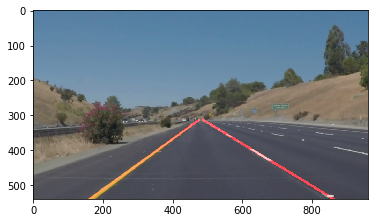

In [175]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [176]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

Left:  -0.7496027463616628
Right:  0.6019776972112036
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



  0%|          | 0/251 [00:00<?, ?it/s]

Left:  -0.7496027463616628
Right:  0.6019776972112036



  0%|          | 1/251 [00:02<11:18,  2.71s/it]

Left:  -0.6593829883338341
Right:  0.582048909451421



  1%|          | 2/251 [00:05<11:23,  2.74s/it]

Left:  -0.6911839292611985
Right:  0.5809682228922836



  1%|          | 3/251 [00:08<11:23,  2.76s/it]

Left:  -0.7263670631041598
Right:  0.5700705970604462



  2%|▏         | 4/251 [00:11<11:19,  2.75s/it]

Left:  -0.6997284022192048
Right:  0.5993527716382558



  2%|▏         | 5/251 [00:13<11:01,  2.69s/it]

Left:  -0.700443496844944
Right:  0.5966893630324139



  2%|▏         | 6/251 [00:16<10:51,  2.66s/it]

Left:  -0.7341840328434899
Right:  0.6158297474192435



  3%|▎         | 7/251 [00:18<10:33,  2.60s/it]

Left:  -0.7021082752206577
Right:  0.6433444932035275



  3%|▎         | 8/251 [00:21<10:21,  2.56s/it]

Left:  -0.6897362992952882
Right:  0.6235325726224619



  4%|▎         | 9/251 [00:23<10:27,  2.59s/it]

Left:  -0.7213557376373607
Right:  0.6081691516821887



  4%|▍         | 10/251 [00:26<10:12,  2.54s/it]

Left:  -0.7160144488892499
Right:  0.6187562735820394



  4%|▍         | 11/251 [00:28<10:01,  2.51s/it]

Left:  -0.7310936975830858
Right:  0.5966546455150206



  5%|▍         | 12/251 [00:31<10:03,  2.52s/it]

Left:  -0.7856059702227552
Right:  0.6070230262229551



  5%|▌         | 13/251 [00:33<10:00,  2.52s/it]

Left:  -0.7497371551211843
Right:  0.5973610521174259



  6%|▌         | 14/251 [00:36<09:53,  2.50s/it]

Left:  -0.7415528269355385
Right:  0.5850924099891471



  6%|▌         | 15/251 [00:38<09:49,  2.50s/it]

Left:  -0.752787811435538
Right:  0.5769448338348053



  6%|▋         | 16/251 [00:41<09:42,  2.48s/it]

Left:  -0.7344253160858666
Right:  0.6025354482095651



  7%|▋         | 17/251 [00:43<09:35,  2.46s/it]

Left:  -0.7502792343921059
Right:  0.5873601404219548



  7%|▋         | 18/251 [00:45<09:34,  2.46s/it]

Left:  -0.7047560170268146
Right:  0.6210724419665447



  8%|▊         | 19/251 [00:48<09:31,  2.46s/it]

Left:  -0.703910991183967
Right:  0.5948681732580038



  8%|▊         | 20/251 [00:50<09:29,  2.47s/it]

Left:  -0.7342352764446248
Right:  0.6125551585718342



  8%|▊         | 21/251 [00:53<09:26,  2.46s/it]

Left:  -0.7018281285054068
Right:  0.5924568048910154



  9%|▉         | 22/251 [00:55<09:23,  2.46s/it]

Left:  -0.720713592406306
Right:  0.5880002213585126



  9%|▉         | 23/251 [00:58<09:20,  2.46s/it]

Left:  -0.7545900730908144
Right:  0.6158483577411313



 10%|▉         | 24/251 [01:00<09:20,  2.47s/it]

Left:  -0.6778546999356758
Right:  0.6243085613406418



 10%|▉         | 25/251 [01:03<09:15,  2.46s/it]

Left:  -0.6729665121743726
Right:  0.633703423254397



 10%|█         | 26/251 [01:05<09:11,  2.45s/it]

Left:  -0.6970012317672573
Right:  0.6344648914144752



 11%|█         | 27/251 [01:08<09:09,  2.45s/it]

Left:  -0.721094308867464
Right:  0.6097027972027972



 11%|█         | 28/251 [01:10<09:07,  2.45s/it]

Left:  -0.7346368460936239
Right:  0.6172210562518808



 12%|█▏        | 29/251 [01:13<09:05,  2.46s/it]

Left:  -0.7316837093712308
Right:  0.6568933571632418



 12%|█▏        | 30/251 [01:15<09:10,  2.49s/it]

Left:  -0.7395942648979976
Right:  0.6046181602330005



 12%|█▏        | 31/251 [01:18<09:24,  2.57s/it]

Left:  -0.7478796798481497
Right:  0.6090888278431813



 13%|█▎        | 32/251 [01:20<09:09,  2.51s/it]

Left:  -0.7571216678035076
Right:  0.6171401207969341



 13%|█▎        | 33/251 [01:23<08:58,  2.47s/it]

Left:  -0.7070777582733112
Right:  0.5929092503998292



 14%|█▎        | 34/251 [01:25<08:50,  2.45s/it]

Left:  -0.7058732534519204
Right:  0.5897943002575807



 14%|█▍        | 35/251 [01:27<08:45,  2.43s/it]

Left:  -0.7434504342534876
Right:  0.5904071017147615



 14%|█▍        | 36/251 [01:30<08:40,  2.42s/it]

Left:  -0.728575631136873
Right:  0.6070715794505216



 15%|█▍        | 37/251 [01:32<08:47,  2.46s/it]

Left:  -0.6876188788988946
Right:  0.5918151365547523



 15%|█▌        | 38/251 [01:35<08:47,  2.48s/it]

Left:  -0.6816123428733079
Right:  0.6242798002726856



 16%|█▌        | 39/251 [01:37<08:49,  2.50s/it]

Left:  -0.7172910631344394
Right:  0.5906860207060806



 16%|█▌        | 40/251 [01:40<08:55,  2.54s/it]

Left:  -0.6734637494420791
Right:  0.6230198430565776



 16%|█▋        | 41/251 [01:42<08:49,  2.52s/it]

Left:  -0.692807572378113
Right:  0.5696505248233453



 17%|█▋        | 42/251 [01:45<08:46,  2.52s/it]

Left:  -0.7115908040680008
Right:  0.5970116231639127



 17%|█▋        | 43/251 [01:48<08:45,  2.52s/it]

Left:  -0.706654779826705
Right:  0.611620394621966



 18%|█▊        | 44/251 [01:50<08:39,  2.51s/it]

Left:  -0.7081819231126357
Right:  0.5737523894422776



 18%|█▊        | 45/251 [01:53<08:45,  2.55s/it]

Left:  -0.7199253239095285
Right:  0.5830444215356647



 18%|█▊        | 46/251 [01:55<08:40,  2.54s/it]

Left:  -0.7238660010113418
Right:  0.5882039245624471



 19%|█▊        | 47/251 [01:58<08:31,  2.51s/it]

Left:  -0.6948208900773498
Right:  0.5971156997852256



 19%|█▉        | 48/251 [02:00<08:26,  2.50s/it]

Left:  -0.6913115065058358
Right:  0.5840976086518237



 20%|█▉        | 49/251 [02:03<08:21,  2.48s/it]

Left:  -0.7234041338536734
Right:  0.5947648259444667



 20%|█▉        | 50/251 [02:05<08:21,  2.50s/it]

Left:  -0.7308914156753609
Right:  0.6250371670396788



 20%|██        | 51/251 [02:08<08:24,  2.52s/it]

Left:  -0.6983238826729838
Right:  0.5607367433467763



 21%|██        | 52/251 [02:10<08:21,  2.52s/it]

Left:  -0.7320460854190031
Right:  0.6093995938055344



 21%|██        | 53/251 [02:13<08:20,  2.53s/it]

Left:  -0.7283614575199219
Right:  0.6139571486139219



 22%|██▏       | 54/251 [02:15<08:18,  2.53s/it]

Left:  -0.7434425618862346
Right:  0.5941153816153817



 22%|██▏       | 55/251 [02:18<08:15,  2.53s/it]

Left:  -0.7136244364572777
Right:  0.6023099887060508



 22%|██▏       | 56/251 [02:20<08:13,  2.53s/it]

Left:  -0.7079207246449845
Right:  0.6653474213542968



 23%|██▎       | 57/251 [02:23<08:12,  2.54s/it]

Left:  -0.722721088908279
Right:  0.6414929967222592



 23%|██▎       | 58/251 [02:25<08:10,  2.54s/it]

Left:  -0.7039701836590075
Right:  0.5851052930031299



 24%|██▎       | 59/251 [02:28<08:06,  2.54s/it]

Left:  -0.7068715173458713
Right:  0.5953032080139227



 24%|██▍       | 60/251 [02:30<08:04,  2.53s/it]

Left:  -0.7449156987808145
Right:  0.611821605039986



 24%|██▍       | 61/251 [02:33<08:14,  2.61s/it]

Left:  -0.7184305385884742
Right:  0.6163865984411324



 25%|██▍       | 62/251 [02:36<08:06,  2.58s/it]

Left:  -0.7596152891404419
Right:  0.6001324458111059



 25%|██▌       | 63/251 [02:38<08:06,  2.59s/it]

Left:  -0.7598779498250179
Right:  0.5912551912581172



 25%|██▌       | 64/251 [02:41<08:04,  2.59s/it]

Left:  -0.7497978811887568
Right:  0.5874473598963394



 26%|██▌       | 65/251 [02:43<07:58,  2.57s/it]

Left:  -0.7935914632044847
Right:  0.6060759670186693



 26%|██▋       | 66/251 [02:46<07:55,  2.57s/it]

Left:  -0.7618635059549607
Right:  0.6340654205607477



 27%|██▋       | 67/251 [02:49<07:52,  2.57s/it]

Left:  -0.7458831011324014
Right:  0.5918093988251468



 27%|██▋       | 68/251 [02:51<07:55,  2.60s/it]

Left:  -0.709875521016345
Right:  0.5862675323565382



 27%|██▋       | 69/251 [02:54<07:48,  2.57s/it]

Left:  -0.6837971263467015
Right:  0.600158421457573



 28%|██▊       | 70/251 [02:56<07:43,  2.56s/it]

Left:  -0.7437692288216973
Right:  0.5728566712842029



 28%|██▊       | 71/251 [02:59<07:41,  2.56s/it]

Left:  -0.6454462576456549
Right:  0.5610088220754263



 29%|██▊       | 72/251 [03:01<07:37,  2.56s/it]

Left:  -0.6736290744627487
Right:  0.6078108338070662



 29%|██▉       | 73/251 [03:04<07:36,  2.56s/it]

Left:  -0.6754326300653931
Right:  0.5673854722452976



 29%|██▉       | 74/251 [03:07<07:33,  2.56s/it]

Left:  -0.7231274103941346
Right:  0.6081258516041125



 30%|██▉       | 75/251 [03:09<07:28,  2.55s/it]

Left:  -0.7368219286554009
Right:  0.5636803307281623



 30%|███       | 76/251 [03:12<07:25,  2.55s/it]

Left:  -0.7214881603787494
Right:  0.6128205124686958



 31%|███       | 77/251 [03:14<07:22,  2.55s/it]

Left:  -0.7394871601866566
Right:  0.568268419769961



 31%|███       | 78/251 [03:17<07:30,  2.60s/it]

Left:  -0.7735993218577628
Right:  0.5488826393750124



 31%|███▏      | 79/251 [03:20<07:27,  2.60s/it]

Left:  -0.7520312316436774
Right:  0.5364711709195298



 32%|███▏      | 80/251 [03:22<07:24,  2.60s/it]

Left:  -0.7836305521739788
Right:  0.5661793023229132



 32%|███▏      | 81/251 [03:25<07:19,  2.59s/it]

Left:  -0.7316718336022304
Right:  0.5540076297912996



 33%|███▎      | 82/251 [03:27<07:14,  2.57s/it]

Left:  -0.8058477057448362
Right:  0.5713072354699216



 33%|███▎      | 83/251 [03:30<07:09,  2.56s/it]

Left:  -0.7370431405325604
Right:  0.5463307226175561



 33%|███▎      | 84/251 [03:32<07:08,  2.57s/it]

Left:  -0.7286754179646402
Right:  0.540331809404816



 34%|███▍      | 85/251 [03:35<07:05,  2.56s/it]

Left:  -0.7492488215924572
Right:  0.5735606216197713



 34%|███▍      | 86/251 [03:37<07:01,  2.56s/it]

Left:  -0.8135922939717758
Right:  0.5915235758297209



 35%|███▍      | 87/251 [03:40<06:56,  2.54s/it]

Left:  -0.8228083150440657
Right:  0.5646777018835687



 35%|███▌      | 88/251 [03:42<06:50,  2.52s/it]

Left:  -0.7661396421149882
Right:  0.5467555581065165



 35%|███▌      | 89/251 [03:45<06:45,  2.50s/it]

Left:  -0.8114895486838309
Right:  0.5977941176470588



 36%|███▌      | 90/251 [03:47<06:38,  2.48s/it]

Left:  -0.705642007390071
Right:  0.598469212246302



 36%|███▋      | 91/251 [03:50<06:42,  2.51s/it]

Left:  -0.7338358049621218
Right:  0.5748617167109843



 37%|███▋      | 92/251 [03:52<06:40,  2.52s/it]

Left:  -0.786465689091077
Right:  0.5498947353254098



 37%|███▋      | 93/251 [03:55<06:34,  2.50s/it]

Left:  -0.8221078947200066
Right:  0.5427442160527165



 37%|███▋      | 94/251 [03:57<06:26,  2.46s/it]

Left:  -0.8487681952608235
Right:  0.5651215167283746



 38%|███▊      | 95/251 [04:00<06:20,  2.44s/it]

Left:  -0.7857796318874516
Right:  0.5771108869345645



 38%|███▊      | 96/251 [04:02<06:16,  2.43s/it]

Left:  -0.7349676840783451
Right:  0.5879738098055457



 39%|███▊      | 97/251 [04:05<06:17,  2.45s/it]

Left:  -0.7337702601473802
Right:  0.524048920581666



 39%|███▉      | 98/251 [04:07<06:19,  2.48s/it]

Left:  -0.8038195185419967
Right:  0.5308627087198515



 39%|███▉      | 99/251 [04:10<06:15,  2.47s/it]

Left:  -0.8169973847998547
Right:  0.6470588235294118



 40%|███▉      | 100/251 [04:12<06:13,  2.48s/it]

Left:  -0.8020260298916227
Right:  0.5305382713094811



 40%|████      | 101/251 [04:14<06:10,  2.47s/it]

Left:  -0.8346560365081117
Right:  0.5419125254155812



 41%|████      | 102/251 [04:17<06:08,  2.47s/it]

Left:  -0.7977489221869994
Right:  0.5434910995036022



 41%|████      | 103/251 [04:19<06:05,  2.47s/it]

Left:  -0.7860153263450423
Right:  0.5464152232188885



 41%|████▏     | 104/251 [04:22<06:04,  2.48s/it]

Left:  -0.7999199308334018
Right:  0.5102040816326531



 42%|████▏     | 105/251 [04:24<06:01,  2.48s/it]

Left:  -0.7817222397633758
Right:  0.5428791682682854



 42%|████▏     | 106/251 [04:27<06:00,  2.49s/it]

Left:  -0.756848526703499
Right:  0.5431221713509389



 43%|████▎     | 107/251 [04:29<06:01,  2.51s/it]

Left:  -1.2287338267592938
Right:  0.6702877344641516



 43%|████▎     | 108/251 [04:32<06:04,  2.55s/it]

Left:  -0.7104672057502247
Right:  0.5707414355162429



 43%|████▎     | 109/251 [04:35<06:18,  2.66s/it]

Left:  -0.8935877390665298
Right:  0.5550239234449761



 44%|████▍     | 110/251 [04:38<06:28,  2.75s/it]

Left:  -0.7837028788834172
Right:  0.6364691515578244



 44%|████▍     | 111/251 [04:41<06:36,  2.83s/it]

Left:  -0.7198185248227558
Right:  2.234998507792859



 45%|████▍     | 112/251 [04:44<06:31,  2.82s/it]

Left:  -0.7836286537356166
Right:  0.5562844161411994



 45%|████▌     | 113/251 [04:47<06:27,  2.80s/it]

Left:  -0.6903195458349894
Right:  0.7411447190319476



 45%|████▌     | 114/251 [04:49<06:30,  2.85s/it]

Left:  -0.6922117669248228
Right:  0.6684950986981816



 46%|████▌     | 115/251 [04:52<06:31,  2.88s/it]

Left:  -0.8304992982854608
Right:  0.537913768326823



 46%|████▌     | 116/251 [04:55<06:25,  2.85s/it]

Left:  -0.8252308318653956
Right:  0.6482420069675371



 47%|████▋     | 117/251 [04:58<06:16,  2.81s/it]

Left:  -0.6948287568455156
Right:  0.5632971862386423



 47%|████▋     | 118/251 [05:01<06:09,  2.77s/it]

Left:  -0.6686062181751837
Right:  0.5696693928578141



 47%|████▋     | 119/251 [05:03<06:09,  2.80s/it]

Left:  -0.5936138827256626
Right:  0.6096219248692641



 48%|████▊     | 120/251 [05:06<06:11,  2.84s/it]

Left:  -0.6796973204504064
Right:  0.6546334627042371



 48%|████▊     | 121/251 [05:09<06:14,  2.88s/it]

Left:  -0.6550973930284275
Right:  0.5918729970320485



 49%|████▊     | 122/251 [05:12<06:07,  2.85s/it]

Left:  -0.67262044653349
Right:  0.5967490070488811



 49%|████▉     | 123/251 [05:15<06:11,  2.90s/it]

Left:  -inf
Right:  0.5598346762788122



 49%|████▉     | 124/251 [05:18<06:05,  2.88s/it]

Left:  -0.6228275682525971
Right:  0.58880492207395



 50%|████▉     | 125/251 [05:21<06:00,  2.86s/it]

Left:  -0.6055859452595279
Right:  0.5947226102193679



 50%|█████     | 126/251 [05:24<05:58,  2.87s/it]

Left:  -0.6383729892344795
Right:  0.5949316010478323



 51%|█████     | 127/251 [05:27<05:56,  2.88s/it]

Left:  -0.6924795973709017
Right:  0.6046476064083534



 51%|█████     | 128/251 [05:30<05:55,  2.89s/it]

Left:  -0.6744038879226322
Right:  0.6077167868444333



 51%|█████▏    | 129/251 [05:32<05:50,  2.88s/it]

Left:  -0.6749056374041154
Right:  0.5840459218720088



 52%|█████▏    | 130/251 [05:35<05:50,  2.89s/it]

Left:  -0.6659485813074981
Right:  0.6096860510716625



 52%|█████▏    | 131/251 [05:38<05:49,  2.91s/it]

Left:  -0.6216842853080846
Right:  0.6371282257094603



 53%|█████▎    | 132/251 [05:41<05:56,  2.99s/it]

Left:  -0.7058616818907255
Right:  0.5983336251671372



 53%|█████▎    | 133/251 [05:45<05:58,  3.04s/it]

Left:  -0.688860246480212
Right:  0.5779970841361697



 53%|█████▎    | 134/251 [05:48<05:52,  3.01s/it]

Left:  -0.6424512456570071
Right:  0.5999816155012057



 54%|█████▍    | 135/251 [05:50<05:46,  2.99s/it]

Left:  -0.6464516779243955
Right:  0.6114635845046021



 54%|█████▍    | 136/251 [05:53<05:42,  2.98s/it]

Left:  -0.6455937044102474
Right:  0.5617070393867829



 55%|█████▍    | 137/251 [05:56<05:37,  2.96s/it]

Left:  -0.6511362090668562
Right:  0.5856006756802594



 55%|█████▍    | 138/251 [05:59<05:31,  2.94s/it]

Left:  -0.6389068970176037
Right:  0.5768776564785472



 55%|█████▌    | 139/251 [06:02<05:32,  2.97s/it]

Left:  -0.6362486991322116
Right:  0.622948352894877



 56%|█████▌    | 140/251 [06:05<05:27,  2.95s/it]

Left:  -0.6806778542395854
Right:  0.5987961022980478



 56%|█████▌    | 141/251 [06:08<05:30,  3.01s/it]

Left:  -3.8588442183646268
Right:  0.6291418907070933



 57%|█████▋    | 142/251 [06:11<05:23,  2.96s/it]

Left:  -2.791442727096446
Right:  0.6200397665367189



 57%|█████▋    | 143/251 [06:14<05:15,  2.92s/it]

Left:  -0.9477480946182926
Right:  0.6238946992538349



 57%|█████▋    | 144/251 [06:17<05:07,  2.88s/it]

Left:  -0.6660569376639466
Right:  0.6055373525769481



 58%|█████▊    | 145/251 [06:20<05:01,  2.85s/it]

Left:  -0.6118205597481592
Right:  0.6003482303260322



 58%|█████▊    | 146/251 [06:23<05:03,  2.89s/it]

Left:  -0.6134956976608285
Right:  0.601430513874746



 59%|█████▊    | 147/251 [06:25<04:58,  2.87s/it]

Left:  -0.5742978342421304
Right:  0.7523809523809524



 59%|█████▉    | 148/251 [06:28<04:55,  2.87s/it]

Left:  -0.5829198530641484
Right:  0.6414235279961805



 59%|█████▉    | 149/251 [06:31<04:54,  2.89s/it]

Left:  -0.6119216269189646
Right:  0.5558102345415779



 60%|█████▉    | 150/251 [06:34<04:46,  2.84s/it]

Left:  -0.6093357336906511
Right:  0.5992266625825681



 60%|██████    | 151/251 [06:36<04:35,  2.76s/it]

Left:  -0.7949582214700509
Right:  0.5769617199126805



 61%|██████    | 152/251 [06:39<04:27,  2.70s/it]

Left:  -0.6137023232661678
Right:  0.5902968283727389



 61%|██████    | 153/251 [06:41<04:16,  2.62s/it]

Left:  -0.6339858866820317
Right:  0.6385983966735146



 61%|██████▏   | 154/251 [06:44<04:09,  2.58s/it]

Left:  -0.6399781687993823
Right:  0.581603626607299



 62%|██████▏   | 155/251 [06:47<04:17,  2.68s/it]

Left:  -0.6856267055004647
Right:  0.620651376882686



 62%|██████▏   | 156/251 [06:50<04:13,  2.67s/it]

Left:  -0.6321976161090265
Right:  0.6303691118283952



 63%|██████▎   | 157/251 [06:52<04:05,  2.61s/it]

Left:  -0.6245629691208582
Right:  0.7362514029180695



 63%|██████▎   | 158/251 [06:55<04:05,  2.64s/it]

Left:  -0.6342988639606705
Right:  0.6530999084190574



 63%|██████▎   | 159/251 [06:57<03:54,  2.55s/it]

Left:  -0.6202691562328191
Right:  0.6804824523968036



 64%|██████▎   | 160/251 [06:59<03:49,  2.52s/it]

Left:  -0.6264816109758171
Right:  0.6617970642093449



 64%|██████▍   | 161/251 [07:02<03:41,  2.46s/it]

Left:  -0.613801046137047
Right:  0.6612287917425371



 65%|██████▍   | 162/251 [07:05<03:45,  2.53s/it]

Left:  -0.5928990675795499
Right:  0.6456588316585857



 65%|██████▍   | 163/251 [07:07<03:40,  2.51s/it]

Left:  -0.6258988284520285
Right:  0.6401849710982659



 65%|██████▌   | 164/251 [07:09<03:37,  2.50s/it]

Left:  -0.5644710214071164
Right:  0.6445406831396637



 66%|██████▌   | 165/251 [07:12<03:34,  2.50s/it]

Left:  -0.5766322094148038
Right:  0.6327818387093433



 66%|██████▌   | 166/251 [07:14<03:33,  2.51s/it]

Left:  -0.5899606118710902
Right:  0.646101342100988



 67%|██████▋   | 167/251 [07:17<03:29,  2.50s/it]

Left:  -0.5889566208624734
Right:  0.6358330374950097



 67%|██████▋   | 168/251 [07:19<03:28,  2.51s/it]

Left:  -0.6102243158742305
Right:  0.6248740115161746



 67%|██████▋   | 169/251 [07:22<03:24,  2.49s/it]

Left:  -0.609002711979836
Right:  0.5929891304828991



 68%|██████▊   | 170/251 [07:24<03:21,  2.48s/it]

Left:  -0.6490441541296584
Right:  0.6493170403565187



 68%|██████▊   | 171/251 [07:27<03:17,  2.47s/it]

Left:  -0.6677752050096234
Right:  0.6534935589565399



 69%|██████▊   | 172/251 [07:29<03:14,  2.47s/it]

Left:  -0.6780029207223301
Right:  0.6272917638419307



 69%|██████▉   | 173/251 [07:32<03:11,  2.46s/it]

Left:  -0.668822707138872
Right:  0.5857940763973479



 69%|██████▉   | 174/251 [07:34<03:10,  2.48s/it]

Left:  -0.6824824072656841
Right:  0.6234982629045723



 70%|██████▉   | 175/251 [07:37<03:10,  2.51s/it]

Left:  -0.6246161126740233
Right:  0.632572504708098



 70%|███████   | 176/251 [07:39<03:09,  2.53s/it]

Left:  -0.6403494973189197
Right:  0.5929388607204636



 71%|███████   | 177/251 [07:42<03:07,  2.53s/it]

Left:  -0.6651280808368235
Right:  0.6133171865863386



 71%|███████   | 178/251 [07:45<03:08,  2.59s/it]

Left:  -0.6024400025600521
Right:  0.5872384228410409



 71%|███████▏  | 179/251 [07:47<03:05,  2.58s/it]

Left:  -0.6441205734147115
Right:  0.5888645570875752



 72%|███████▏  | 180/251 [07:50<03:01,  2.55s/it]

Left:  -0.7069466769433354
Right:  0.5787620125909286



 72%|███████▏  | 181/251 [07:52<03:02,  2.60s/it]

Left:  -0.7296096662058535
Right:  0.5706496110150762



 73%|███████▎  | 182/251 [07:55<02:57,  2.57s/it]

Left:  -0.7299526464773234
Right:  0.5832515400556407



 73%|███████▎  | 183/251 [07:57<02:51,  2.53s/it]

Left:  -0.7717793778035541
Right:  0.5924996613609387



 73%|███████▎  | 184/251 [08:00<02:48,  2.51s/it]

Left:  -0.7341242915792524
Right:  0.5964502049360003



 74%|███████▎  | 185/251 [08:02<02:45,  2.51s/it]

Left:  -0.7827101503737857
Right:  0.5895898204743781



 74%|███████▍  | 186/251 [08:05<02:42,  2.50s/it]

Left:  -0.7471023506261035
Right:  0.6096240179573513



 75%|███████▍  | 187/251 [08:07<02:39,  2.49s/it]

Left:  -0.7268238022672543
Right:  0.5861554288437394



 75%|███████▍  | 188/251 [08:10<02:37,  2.50s/it]

Left:  -0.7735381301110495
Right:  0.5820407721008438



 75%|███████▌  | 189/251 [08:12<02:35,  2.51s/it]

Left:  -0.709957015023927
Right:  0.5881656327891766



 76%|███████▌  | 190/251 [08:15<02:33,  2.52s/it]

Left:  -0.7138306455035113
Right:  0.5890747052528712



 76%|███████▌  | 191/251 [08:17<02:31,  2.53s/it]

Left:  -0.6990347188438069
Right:  0.5836126934791445



 76%|███████▋  | 192/251 [08:20<02:30,  2.55s/it]

Left:  -0.6910932144365627
Right:  0.5772171079036543



 77%|███████▋  | 193/251 [08:23<02:26,  2.53s/it]

Left:  -0.7170307579019354
Right:  0.5984309432585294



 77%|███████▋  | 194/251 [08:25<02:24,  2.53s/it]

Left:  -0.739716333907622
Right:  0.6011410505722202



 78%|███████▊  | 195/251 [08:28<02:20,  2.51s/it]

Left:  -0.7204135674380392
Right:  0.5921661566240094



 78%|███████▊  | 196/251 [08:30<02:20,  2.55s/it]

Left:  -0.7484762342670154
Right:  0.5835751038319072



 78%|███████▊  | 197/251 [08:33<02:19,  2.58s/it]

Left:  -0.7294335540951504
Right:  0.5999320652173913



 79%|███████▉  | 198/251 [08:35<02:16,  2.57s/it]

Left:  -0.7460489810359977
Right:  0.5883125213821416



 79%|███████▉  | 199/251 [08:38<02:14,  2.59s/it]

Left:  -0.7758763225049948
Right:  0.572479876516657



 80%|███████▉  | 200/251 [08:41<02:11,  2.59s/it]

Left:  -0.7159759225322729
Right:  0.5716298790736067



 80%|████████  | 201/251 [08:43<02:10,  2.61s/it]

Left:  -0.748948351965661
Right:  0.5639833897297125



 80%|████████  | 202/251 [08:46<02:06,  2.59s/it]

Left:  -0.7475419263669344
Right:  0.5729080057837914



 81%|████████  | 203/251 [08:48<02:03,  2.58s/it]

Left:  -0.7396603107245222
Right:  0.565665351154655



 81%|████████▏ | 204/251 [08:51<02:01,  2.58s/it]

Left:  -0.7105157891688185
Right:  0.5841011743450767



 82%|████████▏ | 205/251 [08:54<01:58,  2.59s/it]

Left:  -0.7273591009922472
Right:  0.58562861455036



 82%|████████▏ | 206/251 [08:56<01:56,  2.60s/it]

Left:  -0.7525732611171443
Right:  0.5928279608740009



 82%|████████▏ | 207/251 [08:59<01:53,  2.58s/it]

Left:  -0.7717790042086581
Right:  0.5966578964919301



 83%|████████▎ | 208/251 [09:01<01:51,  2.59s/it]

Left:  -0.7527738965229879
Right:  0.5935178395260378



 83%|████████▎ | 209/251 [09:04<01:49,  2.61s/it]

Left:  -0.7494676051633444
Right:  0.5931916601542062



 84%|████████▎ | 210/251 [09:07<01:46,  2.60s/it]

Left:  -0.7251967902188716
Right:  0.5679867000775224



 84%|████████▍ | 211/251 [09:09<01:47,  2.69s/it]

Left:  -0.7756930713989021
Right:  0.5771768609521141



 84%|████████▍ | 212/251 [09:12<01:42,  2.64s/it]

Left:  -0.7456278289043838
Right:  0.5635582168283838



 85%|████████▍ | 213/251 [09:14<01:37,  2.58s/it]

Left:  -0.8013378993067057
Right:  0.5693903963656214



 85%|████████▌ | 214/251 [09:17<01:35,  2.57s/it]

Left:  -0.7948417694272426
Right:  0.5491030489196522



 86%|████████▌ | 215/251 [09:20<01:32,  2.58s/it]

Left:  -0.7967566397354408
Right:  0.579801733417395



 86%|████████▌ | 216/251 [09:22<01:29,  2.56s/it]

Left:  -0.8077569999854451
Right:  0.6118811881188119



 86%|████████▋ | 217/251 [09:25<01:27,  2.57s/it]

Left:  -0.7950685767938538
Right:  0.5433806230840522



 87%|████████▋ | 218/251 [09:27<01:24,  2.57s/it]

Left:  -0.7344398083765779
Right:  0.57564183200847



 87%|████████▋ | 219/251 [09:30<01:22,  2.57s/it]

Left:  -0.7094881412773841
Right:  0.5512566137566137



 88%|████████▊ | 220/251 [09:32<01:19,  2.57s/it]

Left:  -0.7948194351182555
Right:  0.5533168793785445



 88%|████████▊ | 221/251 [09:35<01:17,  2.58s/it]

Left:  -0.7181496296422554
Right:  0.5581805364438392



 88%|████████▊ | 222/251 [09:38<01:14,  2.58s/it]

Left:  -0.7431580307948784
Right:  0.5423138777214196



 89%|████████▉ | 223/251 [09:40<01:12,  2.58s/it]

Left:  -0.7468500548395461
Right:  0.5493835676923768



 89%|████████▉ | 224/251 [09:43<01:09,  2.58s/it]

Left:  -0.7053728348652246
Right:  0.5465484216215803



 90%|████████▉ | 225/251 [09:45<01:07,  2.58s/it]

Left:  -0.7490880443231682
Right:  0.5441490192776206



 90%|█████████ | 226/251 [09:48<01:04,  2.58s/it]

Left:  -0.769928730720148
Right:  0.5843616799526226



 90%|█████████ | 227/251 [09:50<01:02,  2.60s/it]

Left:  -0.7731763320294298
Right:  0.5760550523050524



 91%|█████████ | 228/251 [09:53<00:59,  2.60s/it]

Left:  -0.7815026112591668
Right:  0.5788680499411722



 91%|█████████ | 229/251 [09:56<00:58,  2.67s/it]

Left:  -0.778174584616124
Right:  0.588994088929976



 92%|█████████▏| 230/251 [09:59<00:58,  2.76s/it]

Left:  -0.7433499134559836
Right:  0.5703203369291673



 92%|█████████▏| 231/251 [10:02<00:56,  2.83s/it]

Left:  -0.7174271731404976
Right:  0.5814541744743996



 92%|█████████▏| 232/251 [10:05<00:53,  2.84s/it]

Left:  -0.7378255742638246
Right:  0.5628703367797327



 93%|█████████▎| 233/251 [10:07<00:50,  2.79s/it]

Left:  -0.7263989778506887
Right:  0.5634723396905914



 93%|█████████▎| 234/251 [10:10<00:46,  2.73s/it]

Left:  -0.7206973824754043
Right:  0.5635244693254424



 94%|█████████▎| 235/251 [10:13<00:43,  2.70s/it]

Left:  -0.7059599926477884
Right:  0.5593571494354606



 94%|█████████▍| 236/251 [10:15<00:40,  2.67s/it]

Left:  -0.7523334847315238
Right:  0.5624248513339277



 94%|█████████▍| 237/251 [10:18<00:37,  2.66s/it]

Left:  -0.757517311369475
Right:  0.5872457659878423



 95%|█████████▍| 238/251 [10:21<00:34,  2.66s/it]

Left:  -0.761122741380819
Right:  0.5917531283138919



 95%|█████████▌| 239/251 [10:23<00:32,  2.67s/it]

Left:  -0.7479865598642935
Right:  0.5818439596216818



 96%|█████████▌| 240/251 [10:26<00:29,  2.71s/it]

Left:  -0.7215631433137726
Right:  0.5737493757202552



 96%|█████████▌| 241/251 [10:29<00:27,  2.79s/it]

Left:  -0.6968467045522321
Right:  0.5803158623115914



 96%|█████████▋| 242/251 [10:32<00:25,  2.78s/it]

Left:  -0.7881379760122422
Right:  0.5637279143525039



 97%|█████████▋| 243/251 [10:35<00:22,  2.78s/it]

Left:  -0.70634742806833
Right:  0.5623491103659272



 97%|█████████▋| 244/251 [10:37<00:19,  2.80s/it]

Left:  -0.7254831223425134
Right:  0.5723061676439064



 98%|█████████▊| 245/251 [10:40<00:16,  2.76s/it]

Left:  -0.7057101390965017
Right:  0.5606629448509356



 98%|█████████▊| 246/251 [10:43<00:13,  2.72s/it]

Left:  -0.6912697168885326
Right:  0.5744407766669938



 98%|█████████▊| 247/251 [10:45<00:10,  2.67s/it]

Left:  -0.6890004962330626
Right:  0.5735683948854631



 99%|█████████▉| 248/251 [10:48<00:08,  2.73s/it]

Left:  -0.7456112054497567
Right:  0.5823247339309203



 99%|█████████▉| 249/251 [10:51<00:05,  2.74s/it]

Left:  -0.7569492785373472
Right:  0.6095855210938688



100%|█████████▉| 250/251 [10:53<00:02,  2.70s/it]

Left:  -0.7478750304876863
Right:  0.5839428962670019



100%|██████████| 251/251 [10:56<00:00,  2.72s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 10min 19s, sys: 14.9 s, total: 10min 34s
Wall time: 10min 58s


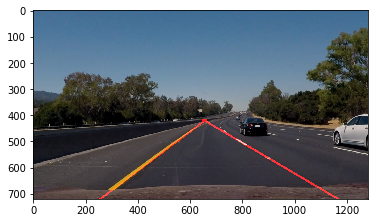

In [173]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [174]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))